In [4]:
#신체적 특성을 기반으로 꽃게의 나이 예측하기

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

In [30]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [8]:
train.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [9]:
train.describe().T

count          mean           std       min           25%  \
id              74051.0  37025.000000  21376.826729  0.000000  18512.500000   
Length          74051.0      1.317460      0.287757  0.187500      1.150000   
Diameter        74051.0      1.024496      0.237396  0.137500      0.887500   
Height          74051.0      0.348089      0.092034  0.000000      0.300000   
Weight          74051.0     23.385217     12.648153  0.056699     13.437663   
Shucked Weight  74051.0     10.104270      5.618025  0.028349      5.712424   
Viscera Weight  74051.0      5.058386      2.792729  0.042524      2.863300   
Shell Weight    74051.0      6.723870      3.584372  0.042524      3.968930   
Age             74051.0      9.967806      3.175189  1.000000      8.000000   

                         50%           75%           max  
id              37025.000000  55537.500000  74050.000000  
Length              1.375000      1.537500      2.012815  
Diameter            1.075000      1.200000      1.612500  
Height              0.362500      0.412500      2.825000  
Weight             23.799405     32.162508     80.101512  
Shucked Weight      9.908150     14.033003     42.184056  
Viscera Weight      4.989512      6.988152     21.545620  
Shell Weight        6.931453      9.071840     28.491248  
Age                10.000000     11.000000     29.000000

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              49368 non-null  int64  
 1   Sex             49368 non-null  object 
 2   Length          49368 non-null  float64
 3   Diameter        49368 non-null  float64
 4   Height          49368 non-null  float64
 5   Weight          49368 non-null  float64
 6   Shucked Weight  49368 non-null  float64
 7   Viscera Weight  49368 non-null  float64
 8   Shell Weight    49368 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.4+ MB


In [11]:
test.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

In [12]:
test.describe().T

count          mean           std           min  \
id              49368.0  98734.500000  14251.458382  74051.000000   
Length          49368.0      1.319795      0.286950      0.187500   
Diameter        49368.0      1.026357      0.236593      0.137500   
Height          49368.0      0.348693      0.092259      0.000000   
Weight          49368.0     23.464627     12.641703      0.056699   
Shucked Weight  49368.0     10.130220      5.611779      0.028349   
Viscera Weight  49368.0      5.072615      2.791563      0.014175   
Shell Weight    49368.0      6.745876      3.575650      0.042524   

                         25%           50%            75%            max  
id              86392.750000  98734.500000  111076.250000  123418.000000  
Length              1.162500      1.387500       1.537500       2.037500  
Diameter            0.887500      1.075000       1.200000       1.625000  
Height              0.300000      0.362500       0.412500       2.825000  
Weight             13.536886     23.813580      32.290081      80.101512  
Shucked Weight      5.740774      9.979024      14.047177      42.184056  
Viscera Weight      2.877474      4.989512       7.016501      21.545620  
Shell Weight        3.968930      6.945627       9.171063      28.491248

In [13]:
train.head(10)

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926   
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   
5   5   M  1.5000    1.1750  0.4125  28.845616       13.409313   
6   6   M  1.5750    1.1375  0.3500  30.022120       11.935140   
7   7   I  1.3125    1.0250  0.3500  18.299602        8.249704   
8   8   F  1.6000    1.2875  0.4375  38.824640       16.967176   
9   9   M  1.0250    0.7625  0.2625  10.305043        4.493396   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.991839     14.996885   11  
4        4.507570      5.953395    8  
5        6.789705      7.937860   10  
6        7.342521      8.646598   11  
7        3.898056      5.669900   11  
8        7.413394     10.772810   12  
9        2.126212      2.976698   11

In [14]:
test.head(10)

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0  74051   I  1.0500    0.7625  0.2750   8.618248        3.657085   
1  74052   I  1.1625    0.8875  0.2750  15.507176        7.030676   
2  74053   F  1.2875    0.9875  0.3250  14.571643        5.556502   
3  74054   F  1.5500    0.9875  0.3875  28.377849       13.380964   
4  74055   I  1.1125    0.8500  0.2625  11.765042        5.528153   
5  74056   M  1.4250    1.1125  0.3500  24.834162        8.731646   
6  74057   M  1.7125    1.3250  0.4500  46.677452       21.233776   
7  74058   I  1.1750    0.8875  0.3000  13.933779        5.698250   
8  74059   F  1.3125    1.0625  0.2875  23.586784        8.164656   
9  74060   F  1.4250    1.0500  0.3125  17.789311        7.101550   

   Viscera Weight  Shell Weight  
0        1.729319      2.721552  
1        3.246018      3.968930  
2        3.883882      4.819415  
3        6.548735      7.030676  
4        2.466407      3.331066  
5        5.712424      8.079607  
6       11.963489     11.368149  
7        2.990872      3.940580  
8        5.627376      8.462326  
9        4.606794      5.528153

## EDA

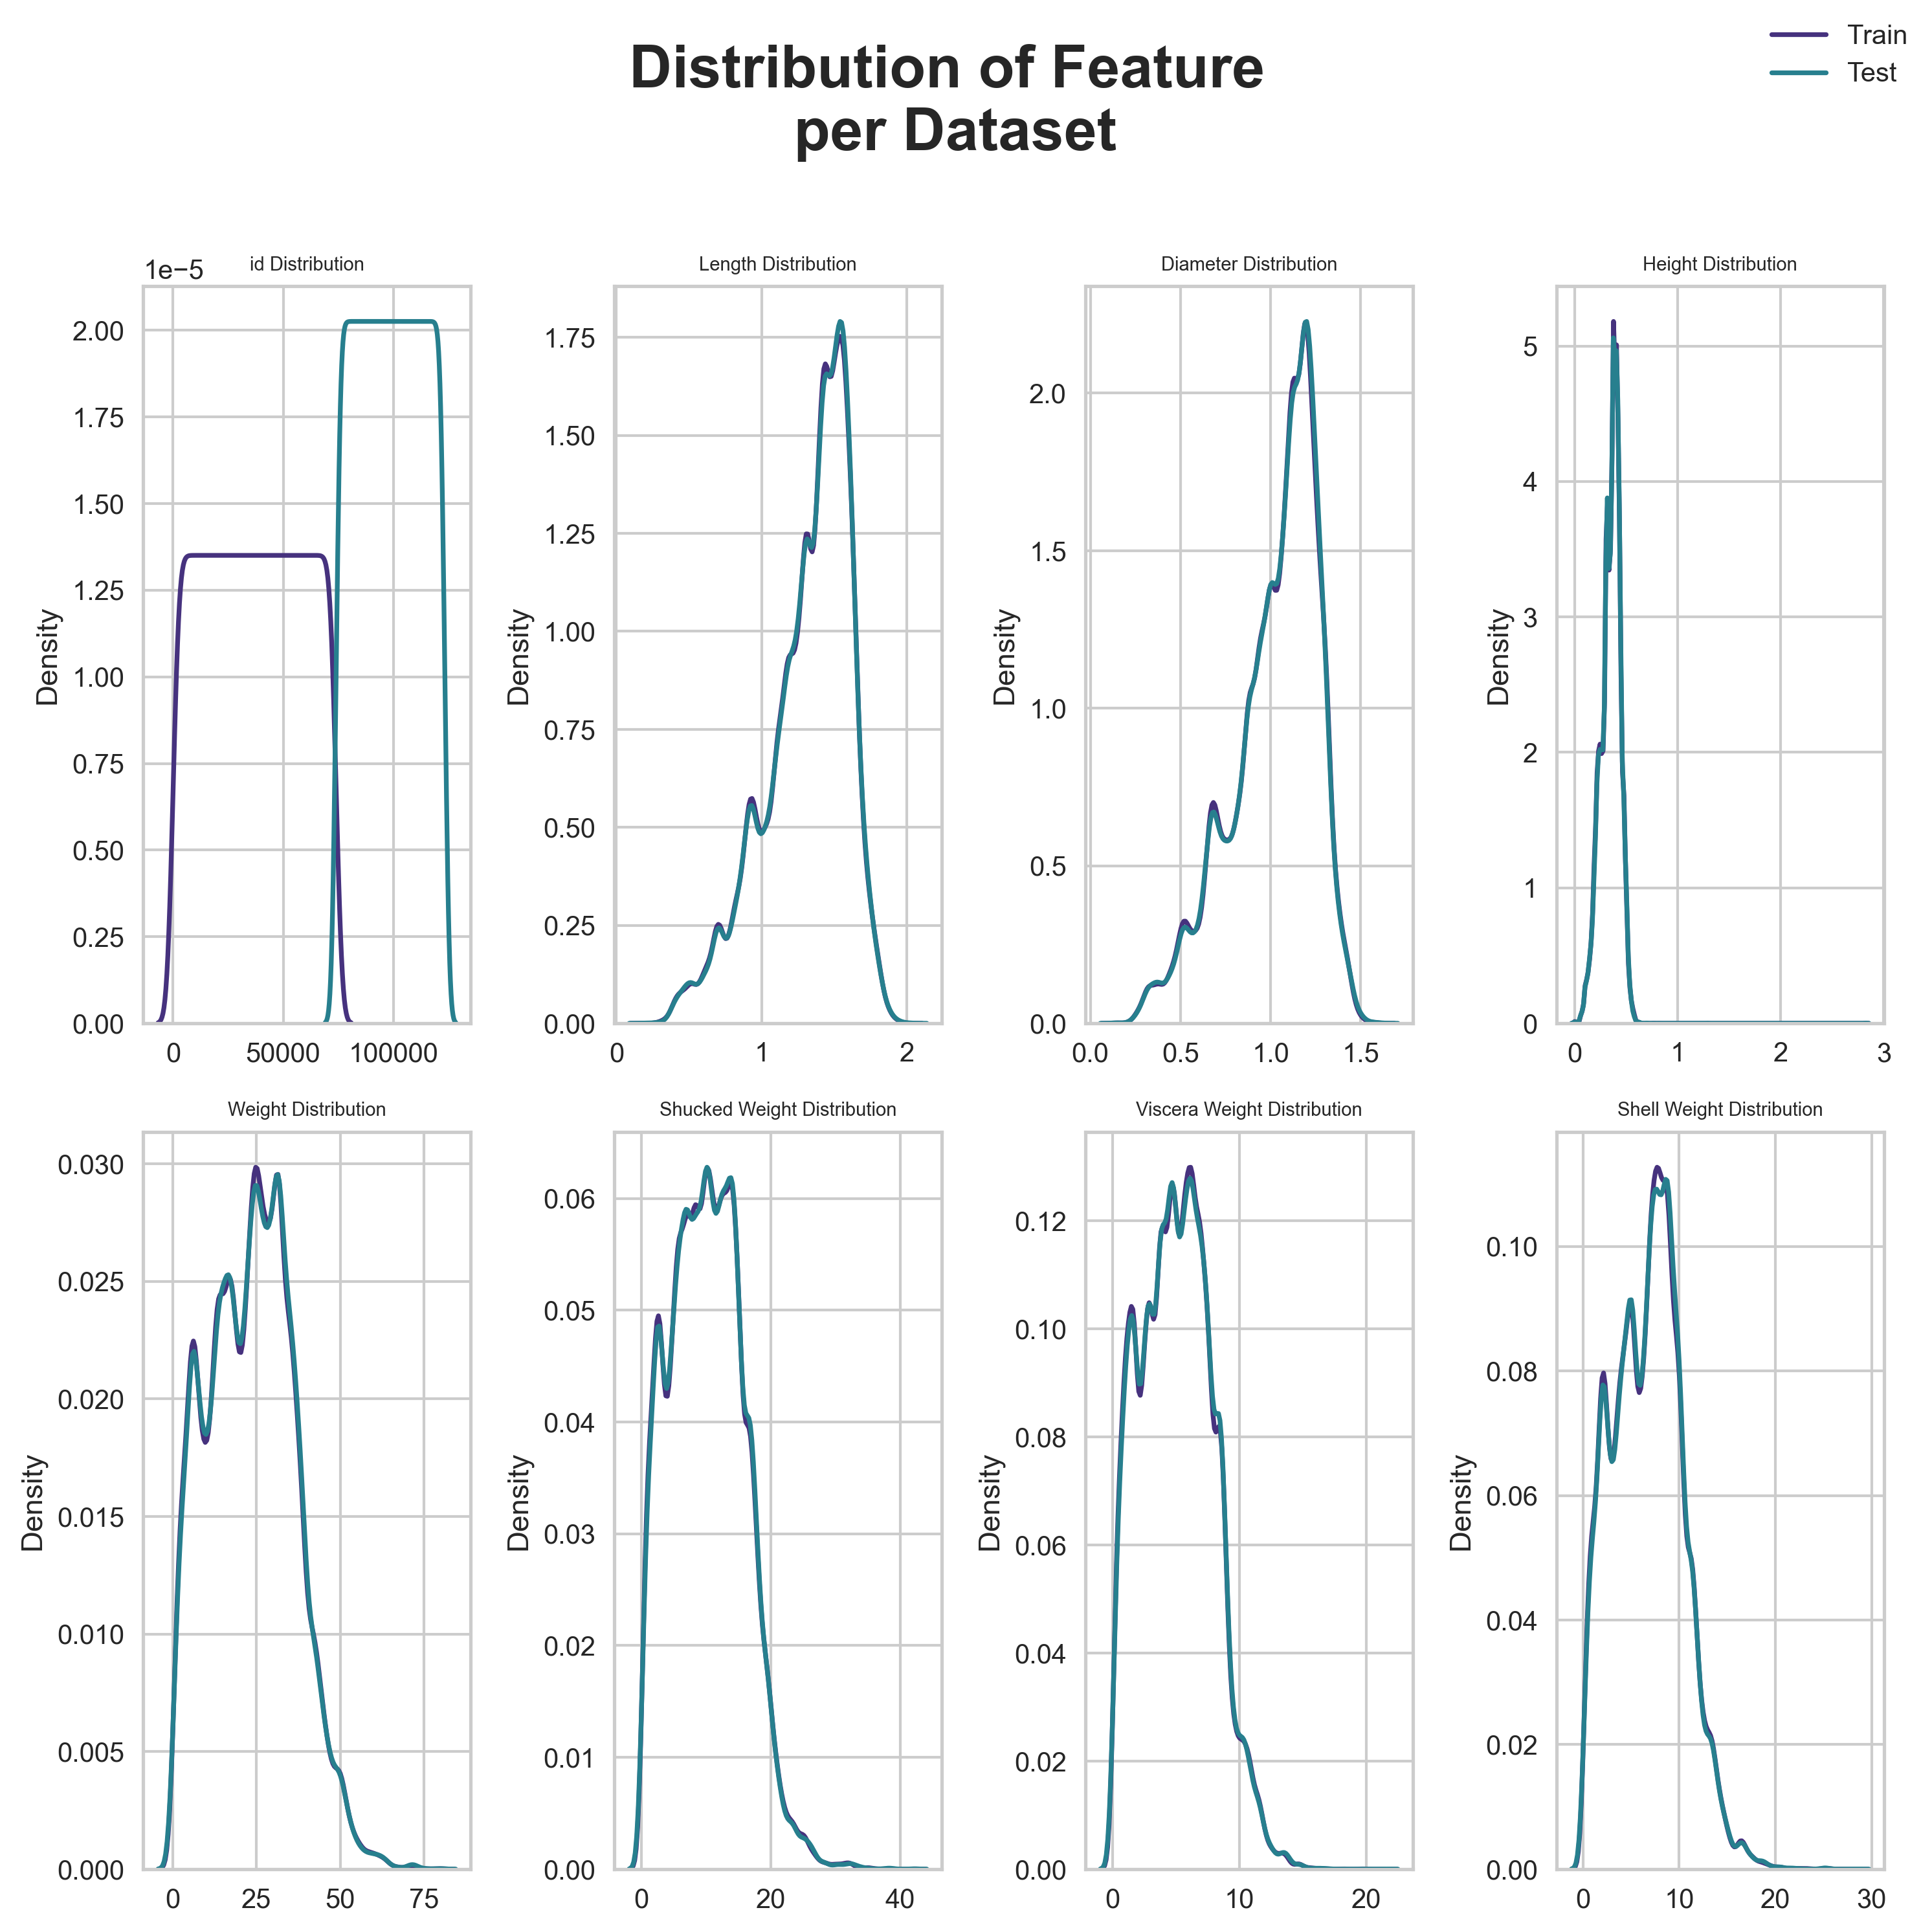

In [15]:
#train data와 test data의 Distribution 비교

numerical_columns = (test.drop('Sex', axis=1)).columns
# numerical_columns
fig, ax = plt.subplots(2, 4, figsize=(10,10), dpi = 300)
ax = ax.flatten() 

for i, column in enumerate(test[numerical_columns]): #인덱스와 값을 동시에 접근 
    sns.kdeplot(train[column], ax = ax[i], color=sns.color_palette('viridis')[0])
    sns.kdeplot(test[column], ax = ax[i], color=sns.color_palette('viridis')[2])
    
    ax[i].set_title(f'{column} Distribution', size=7)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature \n per Dataset \n', fontsize=22, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

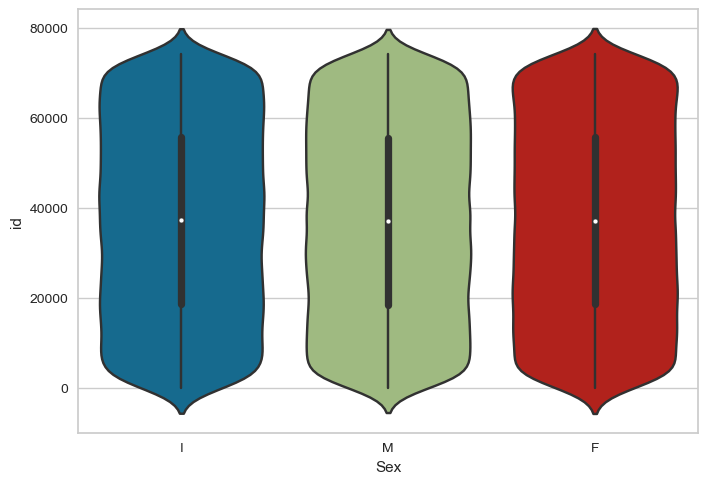

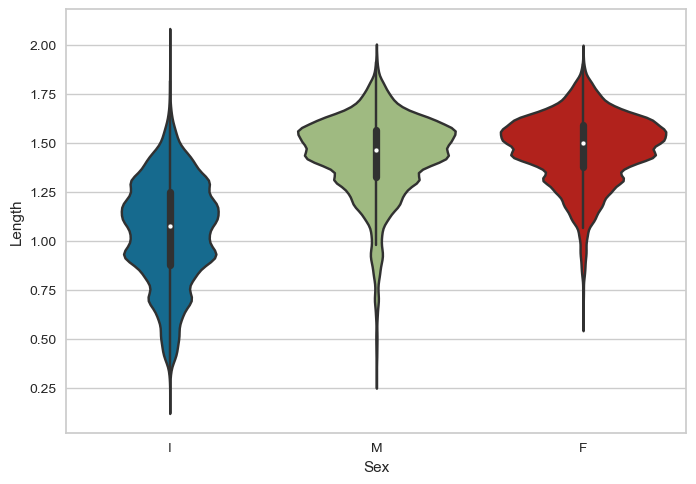

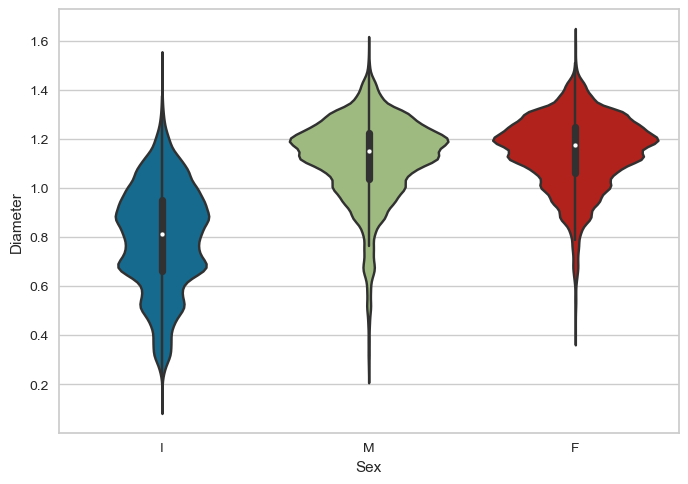

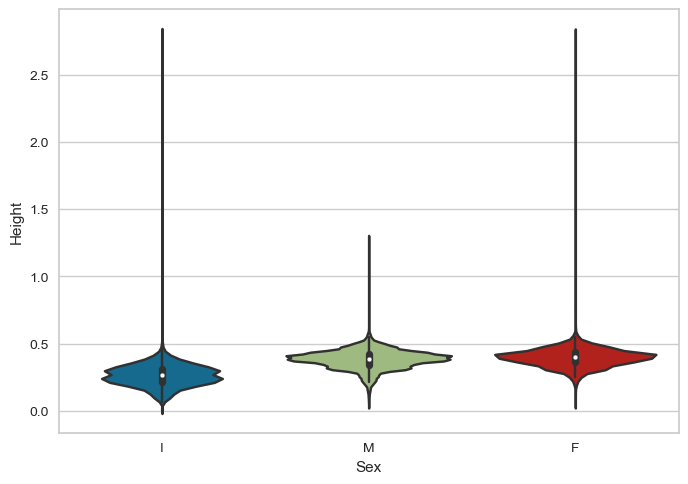

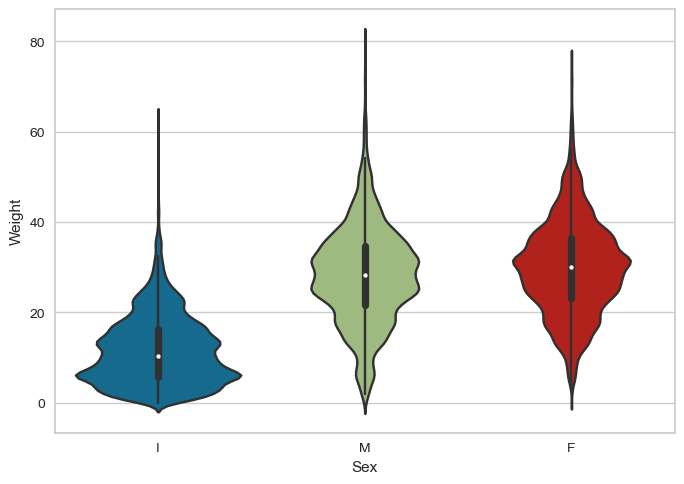

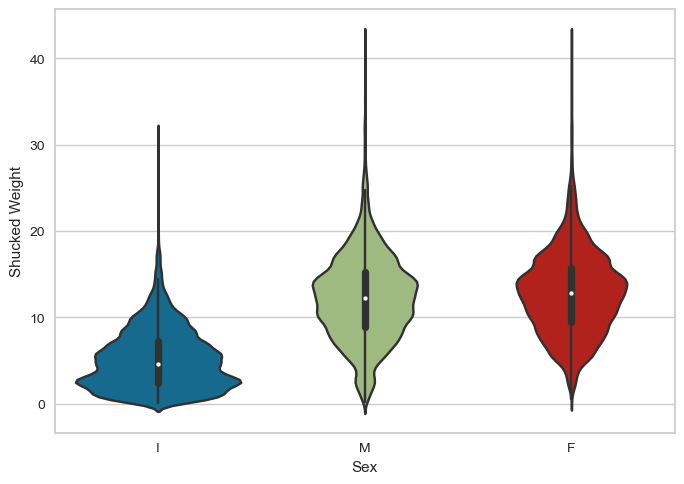

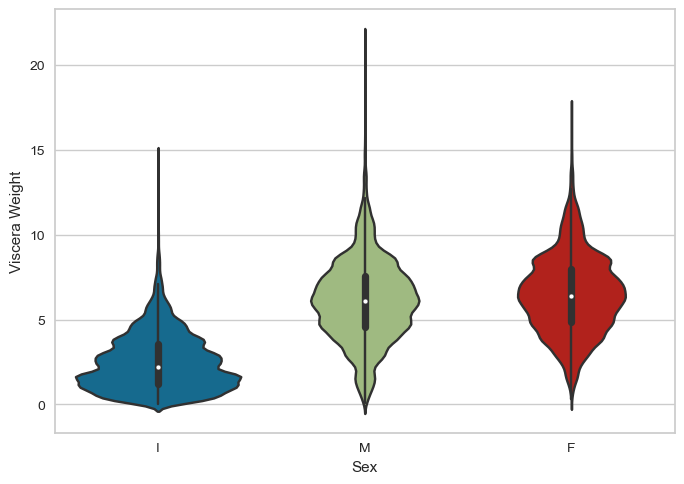

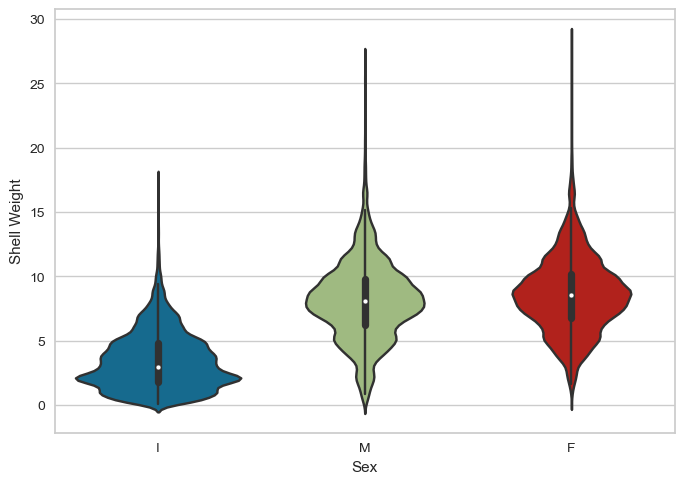

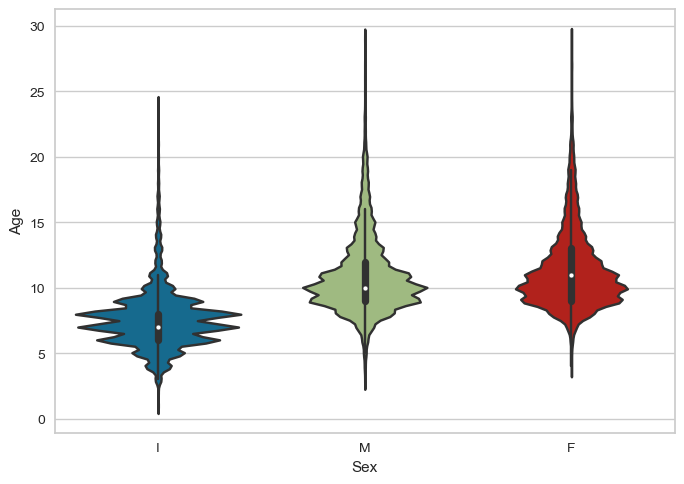

In [16]:
for column in train.select_dtypes(include=[np.number]).columns:
    sns.violinplot(x='Sex', y=column, data=train)
    plt.show()

In [17]:
# male과 female의 신체적 요소들이 모두 비슷한 분포를 가진다
# 성별에서 구분할 수 있는 신체적 특징은 없는 것일까..?

In [18]:
len(train.loc[train['Sex'] == 'M'])

27084

In [19]:
len(train.loc[train['Sex'] == 'F'])

23010

## 데이터 전처리

### Label Encoding

In [31]:
le = LabelEncoder()

train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.fit_transform(test['Sex'])

In [32]:
train.head(10)

id  Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0    1  1.5250    1.1750  0.3750  28.973189       12.728926   
1   1    1  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2    2  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3    0  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4    1  1.2500    1.0125  0.3375  23.289114       11.977664   
5   5    2  1.5000    1.1750  0.4125  28.845616       13.409313   
6   6    2  1.5750    1.1375  0.3500  30.022120       11.935140   
7   7    1  1.3125    1.0250  0.3500  18.299602        8.249704   
8   8    0  1.6000    1.2875  0.4375  38.824640       16.967176   
9   9    2  1.0250    0.7625  0.2625  10.305043        4.493396   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.991839     14.996885   11  
4        4.507570      5.953395    8  
5        6.789705      7.937860   10  
6        7.342521      8.646598   11  
7        3.898056      5.669900   11  
8        7.413394     10.772810   12  
9        2.126212      2.976698   11

In [33]:
test.head(10)

id  Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0  74051    1  1.0500    0.7625  0.2750   8.618248        3.657085   
1  74052    1  1.1625    0.8875  0.2750  15.507176        7.030676   
2  74053    0  1.2875    0.9875  0.3250  14.571643        5.556502   
3  74054    0  1.5500    0.9875  0.3875  28.377849       13.380964   
4  74055    1  1.1125    0.8500  0.2625  11.765042        5.528153   
5  74056    2  1.4250    1.1125  0.3500  24.834162        8.731646   
6  74057    2  1.7125    1.3250  0.4500  46.677452       21.233776   
7  74058    1  1.1750    0.8875  0.3000  13.933779        5.698250   
8  74059    0  1.3125    1.0625  0.2875  23.586784        8.164656   
9  74060    0  1.4250    1.0500  0.3125  17.789311        7.101550   

   Viscera Weight  Shell Weight  
0        1.729319      2.721552  
1        3.246018      3.968930  
2        3.883882      4.819415  
3        6.548735      7.030676  
4        2.466407      3.331066  
5        5.712424      8.079607  
6       11.963489     11.368149  
7        2.990872      3.940580  
8        5.627376      8.462326  
9        4.606794      5.528153

In [34]:
decoded_data = le.inverse_transform(train['Sex'])
decoded_data[:10]

array(['I', 'I', 'M', 'F', 'I', 'M', 'M', 'I', 'F', 'M'], dtype=object)

In [35]:
#I -> 0 / M -> 2 / F -> 0 으로 인코딩됐음을 알 수 있음

### Data Split

In [36]:
#split features
X = train.drop(columns=['id'])
y = train['Age']

#split dat into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
X_train

Sex  Length  Diameter  Height     Weight  Shucked Weight  \
20612    2  1.6125    1.1500  0.4000  31.269499       15.252031   
2935     0  1.5250    1.1750  0.4125  30.220567       12.232809   
73847    2  1.5000    1.1625  0.3875  29.114936       13.125818   
46445    2  1.1250    0.8875  0.2375  12.998246        5.499803   
66755    1  0.8625    0.6375  0.1875   4.280774        1.644271   
...    ...     ...       ...     ...        ...             ...   
37194    1  0.7000    0.5250  0.2000   2.041164        0.935534   
6265     0  1.6500    1.2750  0.5250  39.859397       17.605040   
54886    2  1.6750    1.3500  0.4375  42.013959       20.950281   
860      2  1.5000    1.1750  0.4375  37.747359       12.190285   
15795    1  0.4375    0.3375  0.2375   0.864660        0.311845   

       Viscera Weight  Shell Weight  Age  
20612        6.265239      7.059025    9  
2935         7.002326      8.930093   10  
73847        6.166016      8.079607   12  
46445        2.891649      3.685435   10  
66755        0.737087      1.275727    6  
...               ...           ...  ...  
37194        0.510291      0.765436    5  
6265         8.093782     11.623295   11  
54886        8.292229     10.347568   11  
860          8.221355     10.616888   15  
15795        0.212621      0.283495    6  

[59240 rows x 9 columns]

In [39]:
X_val

Sex  Length  Diameter  Height     Weight  Shucked Weight  \
27233    1  1.6125    1.3500  0.4375  35.692020       14.670866   
55493    1  0.6625    0.5000  0.1625   2.764076        1.133980   
49980    2  1.3500    1.0500  0.3000  21.871639        9.071840   
28319    1  1.1125    0.8000  0.2750  10.418441        4.266600   
20212    1  1.0375    0.8250  0.2500   6.506210        3.061746   
...    ...     ...       ...     ...        ...             ...   
8519     2  1.1250    0.8625  0.2875  14.061352        6.406987   
23448    2  1.5000    1.1875  0.4375  31.467945       13.947954   
12542    2  1.6125    1.2500  0.4000  36.273185       17.718438   
66724    1  0.7250    0.5375  0.0000   3.727959        1.502523   
44994    2  1.9500    1.4500  0.5625  72.432973       35.096681   

       Viscera Weight  Shell Weight  Age  
27233        6.435337     11.056305   18  
55493        0.581165      0.793786    6  
49980        5.684075      6.236890    8  
28319        1.615922      3.401940    8  
20212        1.686795      2.409708    8  
...               ...           ...  ...  
8519         3.316892      3.968930    9  
23448        7.002326      8.788345   10  
12542        7.895336     10.064072   11  
66724        0.765436      1.162330    3  
44994       16.726205     15.308730    9  

[14811 rows x 9 columns]

### Pycaret & LightGBM 설치 

In [40]:
!pip install pycaret

  Using cached pycaret-3.0.4-py3-none-any.whl (484 kB)
  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 4.8 MB/s eta 0:00:0000:01
  Using cached pyod-1.1.0.tar.gz (153 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:0000:0100:01
  Using cached importlib_metadata-6.8.0-py3-none-any.whl (22 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached kaleido-0.2.1-py2.py3-none-macosx_10_11_x86_64.whl (85.2 MB)
  Using cached schemdraw-0.15-py3-none-any.whl (106 kB)
  Using cached plotly_resampler-0.9.1-py3-none-any.whl (73 kB)
  Using cached sktime-0.22.0-py3-none-any.whl (17.5 MB)
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 6.2 MB/s eta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 6.8 MB/s eta 0:00:0000:0100:01
  Using cached dash-2.13.0-py3-none-any.whl (10.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Using cached trace_updater-0.0.9.1-py3-none-any.whl (185 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.5 MB/s eta 0:00:0000:0100:01
  Using cached scikit_base-0.5.1-py3-none-any.whl (118 kB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl (4.1 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl (3.8 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl (3.9 kB)
  Using cached retrying-1.3.4-py3-none-any.whl (11 kB)
  Using cached ansi2html-1.8.0-py3-none-any.whl (16 kB)


  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185331 sha256=7a03e8d5ef54f55d6759e6430a4c967207d2dad3368c73f365f4a871d029d074
  Stored in directory: /Users/yoon/Library/Caches/pip/wheels/d7/21/ce/d0f4083609d89f6c4371a5ecb8c13636e7570abaed1e2473ce
Successfully built pyod
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires d

In [26]:
from pycaret.regression import *

In [46]:
conda install -c conda-forge lightgbm

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3



## Package Plan ##

  environment location: /Users/yoon/opt/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.7.22  |       h8857fd0_0         146 KB  conda-forge
    certifi-2023.7.22          |     pyhd8ed1ab_0         150 KB  conda-forge
    lightgbm-3.3.5             |   py39hc23ddd4_0         1.0 MB  conda-forge
    openssl-1.1.1v             |       h8a1eda9_0         1.7 MB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ------------------------------

In [47]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


### Pycaret 실행

In [62]:
ixi_model = setup(session_id=1, data = X_train, target='Age', test_data = X_val, normalize=True, normalize_method='zscore', transformation=True)

# normalize_method='zscore' - z점수 정규화 : 평균0, 표준편차 1로 만드는 방법
# transformation=True - 데이터 샘플의 분포가 가우시안 분포에 더 가까워지도록 처리
# fold_strategy='stratifiedkfold' - 기본제공 10-fold cross-validation / 이건 다른 fold strategy를 제공하는 것 

In [41]:
#데이터에 대한 설명

In [63]:
#어떤 모델이 있는지 확인
models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   
dummy                       Dummy Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True  
dummy                          sklearn.dummy.DummyRegressor   True

In [64]:
#compare models

pycaret_regression_models = compare_models(n_select=25, sort="MAE")

Processing:   0%|          | 0/104 [00:00<?, ?it/s]

In [65]:
#create_model

catboost_model = create_model('catboost')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
from catboost import CatBoostRegressor

In [78]:
default_catboost_model = CatBoostRegressor()
tuned_catboost_model = tune_model(default_catboost_model, n_iter=100, optimize='MAE')

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0:	learn: 3.1766667	total: 67.4ms	remaining: 2.63s
1:	learn: 3.1766652	total: 75.8ms	remaining: 1.44s
2:	learn: 3.1766638	total: 86.9ms	remaining: 1.07s
3:	learn: 3.1766623	total: 97.6ms	remaining: 879ms
4:	learn: 3.1766608	total: 106ms	remaining: 745ms
5:	learn: 3.1766593	total: 115ms	remaining: 651ms
6:	learn: 3.1766579	total: 124ms	remaining: 585ms
7:	learn: 3.1766564	total: 133ms	remaining: 534ms
8:	learn: 3.1766549	total: 143ms	remaining: 493ms
9:	learn: 3.1766535	total: 153ms	remaining: 458ms
10:	learn: 3.1766521	total: 162ms	remaining: 428ms
11:	learn: 3.1766506	total: 168ms	remaining: 393ms
12:	learn: 3.1766491	total: 180ms	remaining: 373ms
13:	learn: 3.1766476	total: 193ms	remaining: 359ms
14:	learn: 3.1766462	total: 208ms	remaining: 346ms
15:	learn: 3.1766447	total: 222ms	remaining: 334ms
16:	learn: 3.1766432	total: 233ms	remaining: 315ms
17:	learn: 3.1766417	total: 242ms	remaining: 295ms
18:	learn: 3.1766403	to

0:	learn: 2.9501851	total: 61.8ms	remaining: 17.2s
1:	learn: 2.7833062	total: 65ms	remaining: 9.04s
2:	learn: 2.6589901	total: 68ms	remaining: 6.28s
3:	learn: 2.5750611	total: 70.9ms	remaining: 4.89s
4:	learn: 2.5103898	total: 74.1ms	remaining: 4.07s
5:	learn: 2.4626742	total: 77.4ms	remaining: 3.53s
6:	learn: 2.4262195	total: 82.6ms	remaining: 3.22s
7:	learn: 2.3959126	total: 85.3ms	remaining: 2.9s
8:	learn: 2.3733485	total: 87.6ms	remaining: 2.64s
9:	learn: 2.3470871	total: 91.1ms	remaining: 2.46s
10:	learn: 2.3315933	total: 93.8ms	remaining: 2.29s
11:	learn: 2.3214426	total: 96ms	remaining: 2.14s
12:	learn: 2.3015674	total: 100ms	remaining: 2.06s
13:	learn: 2.2846951	total: 103ms	remaining: 1.96s
14:	learn: 2.2756221	total: 105ms	remaining: 1.86s
15:	learn: 2.2636528	total: 108ms	remaining: 1.78s
16:	learn: 2.2542465	total: 111ms	remaining: 1.71s
17:	learn: 2.2429444	total: 114ms	remaining: 1.65s
18:	learn: 2.2381250	total: 117ms	remaining: 1.6s
19:	learn: 2.2304771	total: 120ms	rem

0:	learn: 3.1609594	total: 66ms	remaining: 2.57s
1:	learn: 3.1609580	total: 76.4ms	remaining: 1.45s
2:	learn: 3.1609565	total: 89.5ms	remaining: 1.1s
3:	learn: 3.1609551	total: 103ms	remaining: 926ms
4:	learn: 3.1609536	total: 117ms	remaining: 818ms
5:	learn: 3.1609521	total: 129ms	remaining: 729ms
6:	learn: 3.1609507	total: 140ms	remaining: 659ms
7:	learn: 3.1609493	total: 152ms	remaining: 608ms
8:	learn: 3.1609478	total: 165ms	remaining: 567ms
9:	learn: 3.1609463	total: 178ms	remaining: 534ms
10:	learn: 3.1609449	total: 193ms	remaining: 509ms
11:	learn: 3.1609434	total: 210ms	remaining: 490ms
12:	learn: 3.1609420	total: 227ms	remaining: 471ms
13:	learn: 3.1609405	total: 240ms	remaining: 446ms
14:	learn: 3.1609390	total: 252ms	remaining: 420ms
15:	learn: 3.1609376	total: 266ms	remaining: 399ms
16:	learn: 3.1609361	total: 277ms	remaining: 374ms
17:	learn: 3.1609346	total: 288ms	remaining: 352ms
18:	learn: 3.1609331	total: 300ms	remaining: 332ms
19:	learn: 3.1609317	total: 311ms	remaini

0:	learn: 3.1660799	total: 69ms	remaining: 5.45s
1:	learn: 3.1582654	total: 81.3ms	remaining: 3.17s
2:	learn: 3.1505481	total: 91.5ms	remaining: 2.35s
3:	learn: 3.1428744	total: 102ms	remaining: 1.94s
4:	learn: 3.1352465	total: 111ms	remaining: 1.67s
5:	learn: 3.1276237	total: 120ms	remaining: 1.48s
6:	learn: 3.1200488	total: 130ms	remaining: 1.35s
7:	learn: 3.1124963	total: 139ms	remaining: 1.25s
8:	learn: 3.1049684	total: 150ms	remaining: 1.18s
9:	learn: 3.0976282	total: 158ms	remaining: 1.1s
10:	learn: 3.0902410	total: 170ms	remaining: 1.07s
11:	learn: 3.0829228	total: 181ms	remaining: 1.02s
12:	learn: 3.0756399	total: 193ms	remaining: 997ms
13:	learn: 3.0684535	total: 205ms	remaining: 965ms
14:	learn: 3.0612795	total: 218ms	remaining: 943ms
15:	learn: 3.0542317	total: 232ms	remaining: 928ms
16:	learn: 3.0471758	total: 244ms	remaining: 903ms
17:	learn: 3.0401633	total: 254ms	remaining: 875ms
18:	learn: 3.0331906	total: 264ms	remaining: 847ms
19:	learn: 3.0262778	total: 274ms	remaini

0:	learn: 2.5306414	total: 66.8ms	remaining: 8.62s
1:	learn: 2.2882246	total: 76.7ms	remaining: 4.91s
2:	learn: 2.1901428	total: 89.7ms	remaining: 3.8s
3:	learn: 2.1480158	total: 102ms	remaining: 3.21s
4:	learn: 2.1197510	total: 113ms	remaining: 2.82s
5:	learn: 2.0991732	total: 122ms	remaining: 2.51s
6:	learn: 2.0878875	total: 136ms	remaining: 2.38s
7:	learn: 2.0802628	total: 145ms	remaining: 2.22s
8:	learn: 2.0718367	total: 155ms	remaining: 2.08s
9:	learn: 2.0668674	total: 166ms	remaining: 2s
10:	learn: 2.0621061	total: 177ms	remaining: 1.91s
11:	learn: 2.0578987	total: 185ms	remaining: 1.82s
12:	learn: 2.0509926	total: 191ms	remaining: 1.72s
13:	learn: 2.0489834	total: 210ms	remaining: 1.74s
14:	learn: 2.0472848	total: 221ms	remaining: 1.69s
15:	learn: 2.0436601	total: 239ms	remaining: 1.7s
16:	learn: 2.0412104	total: 248ms	remaining: 1.65s
17:	learn: 2.0365926	total: 261ms	remaining: 1.62s
18:	learn: 2.0323105	total: 270ms	remaining: 1.57s
19:	learn: 2.0311010	total: 282ms	remaining

0:	learn: 3.1696207	total: 67.2ms	remaining: 2.62s
1:	learn: 3.1696192	total: 74.7ms	remaining: 1.42s
2:	learn: 3.1696177	total: 80.4ms	remaining: 991ms
3:	learn: 3.1696163	total: 85.7ms	remaining: 772ms
4:	learn: 3.1696148	total: 90.5ms	remaining: 633ms
5:	learn: 3.1696133	total: 96.4ms	remaining: 546ms
6:	learn: 3.1696119	total: 105ms	remaining: 493ms
7:	learn: 3.1696104	total: 112ms	remaining: 449ms
8:	learn: 3.1696090	total: 120ms	remaining: 412ms
9:	learn: 3.1696075	total: 128ms	remaining: 385ms
10:	learn: 3.1696061	total: 136ms	remaining: 359ms
11:	learn: 3.1696046	total: 144ms	remaining: 335ms
12:	learn: 3.1696031	total: 151ms	remaining: 313ms
13:	learn: 3.1696017	total: 157ms	remaining: 291ms
14:	learn: 3.1696002	total: 162ms	remaining: 270ms
15:	learn: 3.1695987	total: 168ms	remaining: 251ms
16:	learn: 3.1695972	total: 173ms	remaining: 234ms
17:	learn: 3.1695958	total: 179ms	remaining: 219ms
18:	learn: 3.1695943	total: 185ms	remaining: 205ms
19:	learn: 3.1695929	total: 191ms	r

0:	learn: 2.9512234	total: 59.6ms	remaining: 16.6s
1:	learn: 2.7873456	total: 62.2ms	remaining: 8.64s
2:	learn: 2.6625123	total: 63.9ms	remaining: 5.9s
3:	learn: 2.5713748	total: 66.4ms	remaining: 4.58s
4:	learn: 2.5077896	total: 68.4ms	remaining: 3.76s
5:	learn: 2.4592365	total: 70.5ms	remaining: 3.22s
6:	learn: 2.4251124	total: 72.6ms	remaining: 2.83s
7:	learn: 2.4002350	total: 74.6ms	remaining: 2.54s
8:	learn: 2.3797408	total: 76.8ms	remaining: 2.31s
9:	learn: 2.3562362	total: 78.7ms	remaining: 2.13s
10:	learn: 2.3402217	total: 80.7ms	remaining: 1.97s
11:	learn: 2.3195645	total: 82.7ms	remaining: 1.85s
12:	learn: 2.3089316	total: 84.8ms	remaining: 1.74s
13:	learn: 2.2971470	total: 86.6ms	remaining: 1.65s
14:	learn: 2.2775709	total: 88.5ms	remaining: 1.56s
15:	learn: 2.2711237	total: 90.5ms	remaining: 1.49s
16:	learn: 2.2556992	total: 92.5ms	remaining: 1.43s
17:	learn: 2.2474524	total: 95ms	remaining: 1.38s
18:	learn: 2.2356283	total: 98ms	remaining: 1.34s
19:	learn: 2.2309948	total:

0:	learn: 3.1601326	total: 96.1ms	remaining: 23.9s
1:	learn: 3.1472744	total: 112ms	remaining: 13.9s
2:	learn: 3.1346366	total: 117ms	remaining: 9.64s
3:	learn: 3.1221775	total: 130ms	remaining: 7.99s
4:	learn: 3.1098430	total: 139ms	remaining: 6.8s
5:	learn: 3.0976772	total: 144ms	remaining: 5.87s
6:	learn: 3.0857775	total: 150ms	remaining: 5.2s
7:	learn: 3.0741327	total: 173ms	remaining: 5.24s
8:	learn: 3.0625396	total: 182ms	remaining: 4.87s
9:	learn: 3.0511653	total: 191ms	remaining: 4.58s
10:	learn: 3.0399547	total: 199ms	remaining: 4.32s
11:	learn: 3.0290155	total: 211ms	remaining: 4.19s
12:	learn: 3.0181569	total: 218ms	remaining: 3.98s
13:	learn: 3.0073609	total: 226ms	remaining: 3.81s
14:	learn: 2.9968081	total: 237ms	remaining: 3.71s
15:	learn: 2.9864073	total: 244ms	remaining: 3.57s
16:	learn: 2.9761360	total: 252ms	remaining: 3.45s
17:	learn: 2.9661430	total: 261ms	remaining: 3.36s
18:	learn: 2.9563021	total: 267ms	remaining: 3.25s
19:	learn: 2.9465911	total: 274ms	remainin

0:	learn: 2.7153580	total: 105ms	remaining: 25.1s
1:	learn: 2.4476982	total: 156ms	remaining: 18.6s
2:	learn: 2.2905699	total: 219ms	remaining: 17.3s
3:	learn: 2.2004414	total: 295ms	remaining: 17.4s
4:	learn: 2.1442490	total: 339ms	remaining: 15.9s
5:	learn: 2.1104236	total: 380ms	remaining: 14.8s
6:	learn: 2.0873595	total: 434ms	remaining: 14.4s
7:	learn: 2.0726146	total: 495ms	remaining: 14.4s
8:	learn: 2.0615935	total: 541ms	remaining: 13.9s
9:	learn: 2.0536441	total: 586ms	remaining: 13.5s
10:	learn: 2.0481023	total: 661ms	remaining: 13.8s
11:	learn: 2.0432670	total: 752ms	remaining: 14.3s
12:	learn: 2.0382672	total: 824ms	remaining: 14.4s
13:	learn: 2.0332303	total: 883ms	remaining: 14.2s
14:	learn: 2.0281693	total: 970ms	remaining: 14.6s
15:	learn: 2.0235597	total: 1.01s	remaining: 14.2s
16:	learn: 2.0195928	total: 1.07s	remaining: 14s
17:	learn: 2.0140494	total: 1.13s	remaining: 14s
18:	learn: 2.0138864	total: 1.19s	remaining: 13.8s
19:	learn: 2.0072685	total: 1.24s	remaining: 

0:	learn: 2.7299249	total: 138ms	remaining: 32.9s
1:	learn: 2.4630936	total: 197ms	remaining: 23.5s
2:	learn: 2.3042914	total: 288ms	remaining: 22.7s
3:	learn: 2.2130313	total: 349ms	remaining: 20.6s
4:	learn: 2.1568059	total: 396ms	remaining: 18.6s
5:	learn: 2.1237391	total: 448ms	remaining: 17.5s
6:	learn: 2.1012909	total: 486ms	remaining: 16.2s
7:	learn: 2.0861209	total: 533ms	remaining: 15.5s
8:	learn: 2.0743721	total: 582ms	remaining: 14.9s
9:	learn: 2.0671660	total: 650ms	remaining: 15s
10:	learn: 2.0610661	total: 711ms	remaining: 14.8s
11:	learn: 2.0548504	total: 775ms	remaining: 14.7s
12:	learn: 2.0482359	total: 815ms	remaining: 14.2s
13:	learn: 2.0402744	total: 847ms	remaining: 13.7s
14:	learn: 2.0358312	total: 922ms	remaining: 13.8s
15:	learn: 2.0323440	total: 968ms	remaining: 13.6s
16:	learn: 2.0322556	total: 984ms	remaining: 12.9s
17:	learn: 2.0261064	total: 1.06s	remaining: 13.1s
18:	learn: 2.0233966	total: 1.12s	remaining: 13s
19:	learn: 2.0211006	total: 1.17s	remaining: 

0:	learn: 2.7305409	total: 156ms	remaining: 37.4s
1:	learn: 2.4628325	total: 203ms	remaining: 24.2s
2:	learn: 2.3076729	total: 248ms	remaining: 19.6s
3:	learn: 2.2154681	total: 316ms	remaining: 18.6s
4:	learn: 2.1591135	total: 373ms	remaining: 17.6s
5:	learn: 2.1253212	total: 428ms	remaining: 16.7s
6:	learn: 2.1026105	total: 473ms	remaining: 15.7s
7:	learn: 2.0868613	total: 524ms	remaining: 15.2s
8:	learn: 2.0764802	total: 572ms	remaining: 14.7s
9:	learn: 2.0699473	total: 638ms	remaining: 14.7s
10:	learn: 2.0633523	total: 692ms	remaining: 14.4s
11:	learn: 2.0551317	total: 754ms	remaining: 14.3s
12:	learn: 2.0504417	total: 844ms	remaining: 14.7s
13:	learn: 2.0441652	total: 923ms	remaining: 14.9s
14:	learn: 2.0399229	total: 992ms	remaining: 14.9s
15:	learn: 2.0365375	total: 1.06s	remaining: 14.8s
16:	learn: 2.0326041	total: 1.1s	remaining: 14.5s
17:	learn: 2.0269636	total: 1.17s	remaining: 14.4s
18:	learn: 2.0239152	total: 1.22s	remaining: 14.2s
19:	learn: 2.0195547	total: 1.27s	remainin

0:	learn: 2.7291116	total: 177ms	remaining: 42.2s
1:	learn: 2.4644752	total: 307ms	remaining: 36.5s
2:	learn: 2.3082601	total: 362ms	remaining: 28.6s
3:	learn: 2.2142110	total: 414ms	remaining: 24.4s
4:	learn: 2.1589427	total: 474ms	remaining: 22.3s
5:	learn: 2.1262093	total: 565ms	remaining: 22s
6:	learn: 2.1028515	total: 626ms	remaining: 20.8s
7:	learn: 2.0879461	total: 701ms	remaining: 20.3s
8:	learn: 2.0768644	total: 748ms	remaining: 19.2s
9:	learn: 2.0684694	total: 817ms	remaining: 18.8s
10:	learn: 2.0610952	total: 865ms	remaining: 18s
11:	learn: 2.0553126	total: 906ms	remaining: 17.2s
12:	learn: 2.0495900	total: 951ms	remaining: 16.6s
13:	learn: 2.0455556	total: 1s	remaining: 16.2s
14:	learn: 2.0416980	total: 1.06s	remaining: 15.9s
15:	learn: 2.0363708	total: 1.12s	remaining: 15.6s
16:	learn: 2.0320896	total: 1.17s	remaining: 15.3s
17:	learn: 2.0258843	total: 1.22s	remaining: 15.1s
18:	learn: 2.0223056	total: 1.29s	remaining: 15s
19:	learn: 2.0222401	total: 1.31s	remaining: 14.5s

0:	learn: 2.7209540	total: 121ms	remaining: 28.9s
1:	learn: 2.4536054	total: 172ms	remaining: 20.5s
2:	learn: 2.2952515	total: 220ms	remaining: 17.4s
3:	learn: 2.2019046	total: 285ms	remaining: 16.8s
4:	learn: 2.1463954	total: 324ms	remaining: 15.2s
5:	learn: 2.1132070	total: 377ms	remaining: 14.7s
6:	learn: 2.0879538	total: 420ms	remaining: 14s
7:	learn: 2.0731854	total: 484ms	remaining: 14s
8:	learn: 2.0612408	total: 529ms	remaining: 13.6s
9:	learn: 2.0542017	total: 603ms	remaining: 13.9s
10:	learn: 2.0471766	total: 667ms	remaining: 13.9s
11:	learn: 2.0414920	total: 719ms	remaining: 13.7s
12:	learn: 2.0354100	total: 778ms	remaining: 13.6s
13:	learn: 2.0317819	total: 827ms	remaining: 13.4s
14:	learn: 2.0280388	total: 887ms	remaining: 13.3s
15:	learn: 2.0245870	total: 964ms	remaining: 13.5s
16:	learn: 2.0186487	total: 1.01s	remaining: 13.3s
17:	learn: 2.0124798	total: 1.08s	remaining: 13.3s
18:	learn: 2.0097388	total: 1.15s	remaining: 13.3s
19:	learn: 2.0067060	total: 1.19s	remaining: 

0:	learn: 2.7255998	total: 107ms	remaining: 25.7s
1:	learn: 2.4567927	total: 168ms	remaining: 20s
2:	learn: 2.2989554	total: 232ms	remaining: 18.3s
3:	learn: 2.2059470	total: 273ms	remaining: 16.1s
4:	learn: 2.1533369	total: 315ms	remaining: 14.8s
5:	learn: 2.1193175	total: 364ms	remaining: 14.2s
6:	learn: 2.0978046	total: 419ms	remaining: 14s
7:	learn: 2.0822798	total: 468ms	remaining: 13.6s
8:	learn: 2.0712549	total: 524ms	remaining: 13.5s
9:	learn: 2.0627331	total: 565ms	remaining: 13s
10:	learn: 2.0554583	total: 620ms	remaining: 12.9s
11:	learn: 2.0477128	total: 688ms	remaining: 13.1s
12:	learn: 2.0426117	total: 740ms	remaining: 12.9s
13:	learn: 2.0357383	total: 794ms	remaining: 12.8s
14:	learn: 2.0315412	total: 869ms	remaining: 13s
15:	learn: 2.0281811	total: 937ms	remaining: 13.1s
16:	learn: 2.0228473	total: 1000ms	remaining: 13.1s
17:	learn: 2.0173474	total: 1.05s	remaining: 13s
18:	learn: 2.0138233	total: 1.09s	remaining: 12.7s
19:	learn: 2.0103136	total: 1.15s	remaining: 12.6s

0:	learn: 3.1689264	total: 72.7ms	remaining: 11.6s
1:	learn: 3.1689252	total: 79ms	remaining: 6.24s
2:	learn: 3.1689240	total: 83.5ms	remaining: 4.37s
3:	learn: 3.1689228	total: 87.4ms	remaining: 3.41s
4:	learn: 3.1689216	total: 91.6ms	remaining: 2.84s
5:	learn: 3.1689205	total: 98.7ms	remaining: 2.53s
6:	learn: 3.1689193	total: 102ms	remaining: 2.24s
7:	learn: 3.1689181	total: 108ms	remaining: 2.05s
8:	learn: 3.1689169	total: 115ms	remaining: 1.92s
9:	learn: 3.1689157	total: 119ms	remaining: 1.78s
10:	learn: 3.1689146	total: 124ms	remaining: 1.69s
11:	learn: 3.1689134	total: 131ms	remaining: 1.62s
12:	learn: 3.1689123	total: 137ms	remaining: 1.55s
13:	learn: 3.1689111	total: 141ms	remaining: 1.47s
14:	learn: 3.1689099	total: 146ms	remaining: 1.41s
15:	learn: 3.1689087	total: 150ms	remaining: 1.35s
16:	learn: 3.1689075	total: 155ms	remaining: 1.3s
17:	learn: 3.1689064	total: 158ms	remaining: 1.25s
18:	learn: 3.1689052	total: 162ms	remaining: 1.2s
19:	learn: 3.1689040	total: 167ms	remai

0:	learn: 2.7267729	total: 112ms	remaining: 26.7s
1:	learn: 2.4573164	total: 174ms	remaining: 20.7s
2:	learn: 2.3002705	total: 222ms	remaining: 17.6s
3:	learn: 2.2101194	total: 256ms	remaining: 15.1s
4:	learn: 2.1523560	total: 307ms	remaining: 14.4s
5:	learn: 2.1174005	total: 352ms	remaining: 13.7s
6:	learn: 2.0956116	total: 414ms	remaining: 13.8s
7:	learn: 2.0818719	total: 450ms	remaining: 13s
8:	learn: 2.0696792	total: 505ms	remaining: 13s
9:	learn: 2.0626928	total: 553ms	remaining: 12.7s
10:	learn: 2.0547527	total: 607ms	remaining: 12.6s
11:	learn: 2.0486426	total: 658ms	remaining: 12.5s
12:	learn: 2.0424758	total: 705ms	remaining: 12.3s
13:	learn: 2.0405222	total: 765ms	remaining: 12.3s
14:	learn: 2.0354324	total: 824ms	remaining: 12.4s
15:	learn: 2.0294058	total: 881ms	remaining: 12.3s
16:	learn: 2.0293334	total: 894ms	remaining: 11.7s
17:	learn: 2.0262768	total: 960ms	remaining: 11.8s
18:	learn: 2.0228565	total: 1.02s	remaining: 11.9s
19:	learn: 2.0197777	total: 1.08s	remaining: 

173:	learn: 2.0542734	total: 1.78s	remaining: 61.5ms
174:	learn: 2.0542694	total: 1.79s	remaining: 51.3ms
175:	learn: 2.0542652	total: 1.8s	remaining: 41ms
176:	learn: 2.0539215	total: 1.81s	remaining: 30.7ms
177:	learn: 2.0539175	total: 1.82s	remaining: 20.5ms
178:	learn: 2.0533993	total: 1.83s	remaining: 10.2ms
179:	learn: 2.0533925	total: 1.84s	remaining: 0us
0:	learn: 3.1739770	total: 23.2ms	remaining: 3.69s
1:	learn: 3.1739758	total: 27.8ms	remaining: 2.2s
2:	learn: 3.1739746	total: 45.2ms	remaining: 2.37s
3:	learn: 3.1739734	total: 52.9ms	remaining: 2.06s
4:	learn: 3.1739722	total: 58.6ms	remaining: 1.82s
5:	learn: 3.1739710	total: 67.2ms	remaining: 1.72s
6:	learn: 3.1739698	total: 73.4ms	remaining: 1.6s
7:	learn: 3.1739686	total: 83.4ms	remaining: 1.58s
8:	learn: 3.1739674	total: 89.5ms	remaining: 1.5s
9:	learn: 3.1739662	total: 101ms	remaining: 1.51s
10:	learn: 3.1739650	total: 105ms	remaining: 1.42s
11:	learn: 3.1739639	total: 113ms	remaining: 1.4s
12:	learn: 3.1739627	total: 

103:	learn: 3.1695000	total: 1.03s	remaining: 556ms
104:	learn: 3.1694988	total: 1.04s	remaining: 547ms
105:	learn: 3.1694976	total: 1.05s	remaining: 536ms
106:	learn: 3.1694964	total: 1.06s	remaining: 525ms
107:	learn: 3.1694953	total: 1.07s	remaining: 515ms
108:	learn: 3.1694941	total: 1.08s	remaining: 505ms
109:	learn: 3.1694930	total: 1.09s	remaining: 496ms
110:	learn: 3.1694918	total: 1.1s	remaining: 485ms
111:	learn: 3.1694906	total: 1.11s	remaining: 477ms
112:	learn: 3.1694894	total: 1.12s	remaining: 466ms
113:	learn: 3.1694882	total: 1.14s	remaining: 458ms
114:	learn: 3.1694871	total: 1.15s	remaining: 449ms
115:	learn: 3.1694859	total: 1.17s	remaining: 444ms
116:	learn: 3.1694847	total: 1.21s	remaining: 443ms
117:	learn: 3.1694835	total: 1.22s	remaining: 433ms
118:	learn: 3.1694823	total: 1.23s	remaining: 425ms
119:	learn: 3.1694811	total: 1.25s	remaining: 415ms
120:	learn: 3.1694799	total: 1.25s	remaining: 404ms
121:	learn: 3.1694788	total: 1.26s	remaining: 392ms
122:	learn: 3

95:	learn: 3.1711656	total: 974ms	remaining: 649ms
96:	learn: 3.1711644	total: 983ms	remaining: 638ms
97:	learn: 3.1711632	total: 991ms	remaining: 627ms
98:	learn: 3.1711621	total: 1s	remaining: 618ms
99:	learn: 3.1711610	total: 1.01s	remaining: 608ms
100:	learn: 3.1711598	total: 1.02s	remaining: 596ms
101:	learn: 3.1711586	total: 1.03s	remaining: 586ms
102:	learn: 3.1711574	total: 1.04s	remaining: 577ms
103:	learn: 3.1711563	total: 1.05s	remaining: 566ms
104:	learn: 3.1711551	total: 1.06s	remaining: 555ms
105:	learn: 3.1711540	total: 1.07s	remaining: 544ms
106:	learn: 3.1711528	total: 1.08s	remaining: 534ms
107:	learn: 3.1711517	total: 1.09s	remaining: 524ms
108:	learn: 3.1711505	total: 1.1s	remaining: 514ms
109:	learn: 3.1711494	total: 1.11s	remaining: 503ms
110:	learn: 3.1711482	total: 1.12s	remaining: 494ms
111:	learn: 3.1711470	total: 1.13s	remaining: 483ms
112:	learn: 3.1711458	total: 1.13s	remaining: 472ms
113:	learn: 3.1711447	total: 1.14s	remaining: 461ms
114:	learn: 3.1711435

13:	learn: 3.0687609	total: 501ms	remaining: 9.88s
14:	learn: 3.0614654	total: 525ms	remaining: 9.63s
15:	learn: 3.0542306	total: 557ms	remaining: 9.54s
16:	learn: 3.0470338	total: 623ms	remaining: 10s
17:	learn: 3.0399047	total: 670ms	remaining: 10.1s
18:	learn: 3.0327985	total: 709ms	remaining: 10.1s
19:	learn: 3.0258131	total: 752ms	remaining: 10.1s
20:	learn: 3.0188637	total: 793ms	remaining: 10.2s
21:	learn: 3.0119706	total: 829ms	remaining: 10.1s
22:	learn: 3.0050541	total: 854ms	remaining: 9.91s
23:	learn: 2.9982036	total: 885ms	remaining: 9.81s
24:	learn: 2.9913610	total: 912ms	remaining: 9.67s
25:	learn: 2.9845956	total: 949ms	remaining: 9.63s
26:	learn: 2.9778952	total: 994ms	remaining: 9.69s
27:	learn: 2.9712793	total: 1.03s	remaining: 9.65s
28:	learn: 2.9647058	total: 1.05s	remaining: 9.47s
29:	learn: 2.9581111	total: 1.08s	remaining: 9.37s
30:	learn: 2.9516091	total: 1.11s	remaining: 9.26s
31:	learn: 2.9451403	total: 1.15s	remaining: 9.26s
32:	learn: 2.9387137	total: 1.18s

13:	learn: 3.1575416	total: 129ms	remaining: 2.08s
14:	learn: 3.1563781	total: 138ms	remaining: 2.07s
15:	learn: 3.1552226	total: 143ms	remaining: 2s
16:	learn: 3.1540656	total: 152ms	remaining: 2s
17:	learn: 3.1529104	total: 157ms	remaining: 1.93s
18:	learn: 3.1517496	total: 174ms	remaining: 2.03s
19:	learn: 3.1505986	total: 181ms	remaining: 1.99s
20:	learn: 3.1494441	total: 185ms	remaining: 1.93s
21:	learn: 3.1482985	total: 192ms	remaining: 1.9s
22:	learn: 3.1471595	total: 196ms	remaining: 1.85s
23:	learn: 3.1460078	total: 202ms	remaining: 1.82s
24:	learn: 3.1448678	total: 210ms	remaining: 1.8s
25:	learn: 3.1437308	total: 220ms	remaining: 1.81s
26:	learn: 3.1425893	total: 231ms	remaining: 1.82s
27:	learn: 3.1414449	total: 236ms	remaining: 1.78s
28:	learn: 3.1403131	total: 240ms	remaining: 1.75s
29:	learn: 3.1391724	total: 246ms	remaining: 1.72s
30:	learn: 3.1380336	total: 251ms	remaining: 1.7s
31:	learn: 3.1369046	total: 257ms	remaining: 1.67s
32:	learn: 3.1357732	total: 266ms	remain

93:	learn: 2.6206165	total: 3.17s	remaining: 6.61s
94:	learn: 2.6165263	total: 3.2s	remaining: 6.58s
95:	learn: 2.6125091	total: 3.23s	remaining: 6.53s
96:	learn: 2.6084397	total: 3.27s	remaining: 6.5s
97:	learn: 2.6044348	total: 3.29s	remaining: 6.45s
98:	learn: 2.6004593	total: 3.31s	remaining: 6.4s
99:	learn: 2.5965766	total: 3.35s	remaining: 6.37s
100:	learn: 2.5927294	total: 3.39s	remaining: 6.34s
101:	learn: 2.5888328	total: 3.42s	remaining: 6.3s
102:	learn: 2.5849626	total: 3.45s	remaining: 6.26s
103:	learn: 2.5811353	total: 3.5s	remaining: 6.25s
104:	learn: 2.5773214	total: 3.54s	remaining: 6.23s
105:	learn: 2.5736037	total: 3.57s	remaining: 6.19s
106:	learn: 2.5698135	total: 3.6s	remaining: 6.16s
107:	learn: 2.5660425	total: 3.64s	remaining: 6.13s
108:	learn: 2.5623088	total: 3.67s	remaining: 6.1s
109:	learn: 2.5586309	total: 3.71s	remaining: 6.07s
110:	learn: 2.5550283	total: 3.74s	remaining: 6.03s
111:	learn: 2.5514253	total: 3.78s	remaining: 6s
112:	learn: 2.5478814	total: 

0:	learn: 2.9451370	total: 151ms	remaining: 27s
1:	learn: 2.7619241	total: 220ms	remaining: 19.6s
2:	learn: 2.6158622	total: 310ms	remaining: 18.3s
3:	learn: 2.5000629	total: 365ms	remaining: 16s
4:	learn: 2.4093999	total: 415ms	remaining: 14.5s
5:	learn: 2.3392081	total: 459ms	remaining: 13.3s
6:	learn: 2.2853727	total: 501ms	remaining: 12.4s
7:	learn: 2.2409146	total: 569ms	remaining: 12.2s
8:	learn: 2.2061615	total: 625ms	remaining: 11.9s
9:	learn: 2.1792086	total: 667ms	remaining: 11.3s
10:	learn: 2.1571099	total: 712ms	remaining: 10.9s
11:	learn: 2.1390042	total: 765ms	remaining: 10.7s
12:	learn: 2.1249513	total: 811ms	remaining: 10.4s
13:	learn: 2.1129910	total: 867ms	remaining: 10.3s
14:	learn: 2.1032330	total: 912ms	remaining: 10s
15:	learn: 2.0944696	total: 978ms	remaining: 10s
16:	learn: 2.0875382	total: 1.02s	remaining: 9.81s
17:	learn: 2.0817011	total: 1.08s	remaining: 9.71s
18:	learn: 2.0763348	total: 1.13s	remaining: 9.6s
19:	learn: 2.0721329	total: 1.19s	remaining: 9.52s

94:	learn: 3.0307910	total: 1.28s	remaining: 337ms
95:	learn: 3.0295174	total: 1.29s	remaining: 322ms
96:	learn: 3.0282488	total: 1.3s	remaining: 308ms
97:	learn: 3.0269736	total: 1.31s	remaining: 295ms
98:	learn: 3.0257054	total: 1.33s	remaining: 282ms
99:	learn: 3.0244119	total: 1.34s	remaining: 268ms
100:	learn: 3.0231360	total: 1.35s	remaining: 255ms
101:	learn: 3.0218722	total: 1.36s	remaining: 240ms
102:	learn: 3.0205914	total: 1.38s	remaining: 227ms
103:	learn: 3.0193306	total: 1.4s	remaining: 215ms
104:	learn: 3.0180791	total: 1.41s	remaining: 201ms
105:	learn: 3.0168103	total: 1.43s	remaining: 188ms
106:	learn: 3.0155521	total: 1.43s	remaining: 174ms
107:	learn: 3.0142975	total: 1.45s	remaining: 161ms
108:	learn: 3.0130311	total: 1.46s	remaining: 148ms
109:	learn: 3.0117829	total: 1.47s	remaining: 134ms
110:	learn: 3.0105340	total: 1.49s	remaining: 121ms
111:	learn: 3.0092862	total: 1.5s	remaining: 107ms
112:	learn: 3.0080275	total: 1.51s	remaining: 93.9ms
113:	learn: 3.006783

155:	learn: 1.9711034	total: 8s	remaining: 1.23s
156:	learn: 1.9696851	total: 8.05s	remaining: 1.18s
157:	learn: 1.9688425	total: 8.11s	remaining: 1.13s
158:	learn: 1.9676973	total: 8.15s	remaining: 1.08s
159:	learn: 1.9661441	total: 8.21s	remaining: 1.02s
160:	learn: 1.9646904	total: 8.26s	remaining: 974ms
161:	learn: 1.9641566	total: 8.32s	remaining: 925ms
162:	learn: 1.9627478	total: 8.38s	remaining: 874ms
163:	learn: 1.9617041	total: 8.45s	remaining: 825ms
164:	learn: 1.9605530	total: 8.51s	remaining: 773ms
165:	learn: 1.9605363	total: 8.59s	remaining: 724ms
166:	learn: 1.9605314	total: 8.64s	remaining: 672ms
167:	learn: 1.9597230	total: 8.7s	remaining: 621ms
168:	learn: 1.9588249	total: 8.75s	remaining: 569ms
169:	learn: 1.9585781	total: 8.79s	remaining: 517ms
170:	learn: 1.9576638	total: 8.84s	remaining: 465ms
171:	learn: 1.9569754	total: 8.89s	remaining: 414ms
172:	learn: 1.9569540	total: 8.96s	remaining: 363ms
173:	learn: 1.9569099	total: 9s	remaining: 310ms
174:	learn: 1.95639

215:	learn: 1.7529234	total: 12.8s	remaining: 4.39s
216:	learn: 1.7524366	total: 12.9s	remaining: 4.32s
217:	learn: 1.7523371	total: 12.9s	remaining: 4.27s
218:	learn: 1.7507666	total: 13s	remaining: 4.21s
219:	learn: 1.7497931	total: 13s	remaining: 4.15s
220:	learn: 1.7488064	total: 13.1s	remaining: 4.08s
221:	learn: 1.7472448	total: 13.1s	remaining: 4.02s
222:	learn: 1.7455828	total: 13.2s	remaining: 3.96s
223:	learn: 1.7445693	total: 13.3s	remaining: 3.91s
224:	learn: 1.7436431	total: 13.3s	remaining: 3.85s
225:	learn: 1.7429681	total: 13.4s	remaining: 3.79s
226:	learn: 1.7412673	total: 13.5s	remaining: 3.74s
227:	learn: 1.7398429	total: 13.6s	remaining: 3.69s
228:	learn: 1.7394879	total: 13.6s	remaining: 3.62s
229:	learn: 1.7385666	total: 13.6s	remaining: 3.56s
230:	learn: 1.7373911	total: 13.7s	remaining: 3.5s
231:	learn: 1.7360894	total: 13.8s	remaining: 3.44s
232:	learn: 1.7344100	total: 13.8s	remaining: 3.38s
233:	learn: 1.7335082	total: 13.9s	remaining: 3.32s
234:	learn: 1.732

198:	learn: 1.7671378	total: 12.2s	remaining: 5.58s
199:	learn: 1.7654302	total: 12.3s	remaining: 5.53s
200:	learn: 1.7646330	total: 12.4s	remaining: 5.47s
201:	learn: 1.7634701	total: 12.4s	remaining: 5.42s
202:	learn: 1.7627157	total: 12.5s	remaining: 5.35s
203:	learn: 1.7610413	total: 12.6s	remaining: 5.29s
204:	learn: 1.7597571	total: 12.6s	remaining: 5.23s
205:	learn: 1.7586723	total: 12.7s	remaining: 5.17s
206:	learn: 1.7584877	total: 12.7s	remaining: 5.11s
207:	learn: 1.7580059	total: 12.8s	remaining: 5.04s
208:	learn: 1.7572386	total: 12.9s	remaining: 4.99s
209:	learn: 1.7565410	total: 12.9s	remaining: 4.93s
210:	learn: 1.7548382	total: 13s	remaining: 4.87s
211:	learn: 1.7533271	total: 13s	remaining: 4.8s
212:	learn: 1.7527802	total: 13.1s	remaining: 4.73s
213:	learn: 1.7524681	total: 13.1s	remaining: 4.66s
214:	learn: 1.7523165	total: 13.2s	remaining: 4.59s
215:	learn: 1.7514139	total: 13.2s	remaining: 4.53s
216:	learn: 1.7504457	total: 13.3s	remaining: 4.46s
217:	learn: 1.748

166:	learn: 1.8193040	total: 9.85s	remaining: 7.26s
167:	learn: 1.8184740	total: 9.9s	remaining: 7.19s
168:	learn: 1.8170735	total: 9.96s	remaining: 7.13s
169:	learn: 1.8153415	total: 10s	remaining: 7.06s
170:	learn: 1.8139493	total: 10s	remaining: 6.99s
171:	learn: 1.8128684	total: 10.1s	remaining: 6.92s
172:	learn: 1.8117247	total: 10.2s	remaining: 6.87s
173:	learn: 1.8109184	total: 10.2s	remaining: 6.81s
174:	learn: 1.8099905	total: 10.3s	remaining: 6.74s
175:	learn: 1.8093508	total: 10.3s	remaining: 6.68s
176:	learn: 1.8074868	total: 10.4s	remaining: 6.62s
177:	learn: 1.8056965	total: 10.4s	remaining: 6.56s
178:	learn: 1.8038807	total: 10.5s	remaining: 6.49s
179:	learn: 1.8022042	total: 10.5s	remaining: 6.43s
180:	learn: 1.8008174	total: 10.6s	remaining: 6.37s
181:	learn: 1.7998406	total: 10.6s	remaining: 6.3s
182:	learn: 1.7991510	total: 10.7s	remaining: 6.24s
183:	learn: 1.7975724	total: 10.7s	remaining: 6.18s
184:	learn: 1.7966544	total: 10.8s	remaining: 6.13s
185:	learn: 1.7952

169:	learn: 2.0343890	total: 3.33s	remaining: 1.37s
170:	learn: 2.0343854	total: 3.33s	remaining: 1.34s
171:	learn: 2.0339481	total: 3.34s	remaining: 1.32s
172:	learn: 2.0334808	total: 3.36s	remaining: 1.3s
173:	learn: 2.0334671	total: 3.38s	remaining: 1.28s
174:	learn: 2.0329099	total: 3.41s	remaining: 1.26s
175:	learn: 2.0329062	total: 3.42s	remaining: 1.25s
176:	learn: 2.0329019	total: 3.44s	remaining: 1.22s
177:	learn: 2.0328979	total: 3.46s	remaining: 1.21s
178:	learn: 2.0328782	total: 3.5s	remaining: 1.19s
179:	learn: 2.0323196	total: 3.53s	remaining: 1.18s
180:	learn: 2.0323160	total: 3.54s	remaining: 1.15s
181:	learn: 2.0323124	total: 3.56s	remaining: 1.13s
182:	learn: 2.0322791	total: 3.6s	remaining: 1.12s
183:	learn: 2.0322755	total: 3.61s	remaining: 1.1s
184:	learn: 2.0317982	total: 3.62s	remaining: 1.08s
185:	learn: 2.0317945	total: 3.64s	remaining: 1.06s
186:	learn: 2.0316998	total: 3.65s	remaining: 1.03s
187:	learn: 2.0316906	total: 3.67s	remaining: 1.01s
188:	learn: 2.03

76:	learn: 2.4513971	total: 1.93s	remaining: 3.33s
77:	learn: 2.4463129	total: 1.95s	remaining: 3.3s
78:	learn: 2.4414042	total: 1.98s	remaining: 3.29s
79:	learn: 2.4365147	total: 2s	remaining: 3.26s
80:	learn: 2.4317566	total: 2.02s	remaining: 3.21s
81:	learn: 2.4270366	total: 2.05s	remaining: 3.2s
82:	learn: 2.4223585	total: 2.06s	remaining: 3.16s
83:	learn: 2.4178897	total: 2.07s	remaining: 3.11s
84:	learn: 2.4134999	total: 2.11s	remaining: 3.11s
85:	learn: 2.4090613	total: 2.14s	remaining: 3.09s
86:	learn: 2.4044929	total: 2.16s	remaining: 3.06s
87:	learn: 2.4003313	total: 2.19s	remaining: 3.03s
88:	learn: 2.3960978	total: 2.21s	remaining: 3s
89:	learn: 2.3917631	total: 2.22s	remaining: 2.96s
90:	learn: 2.3876064	total: 2.24s	remaining: 2.94s
91:	learn: 2.3835580	total: 2.28s	remaining: 2.92s
92:	learn: 2.3794421	total: 2.29s	remaining: 2.88s
93:	learn: 2.3755073	total: 2.34s	remaining: 2.89s
94:	learn: 2.3716712	total: 2.38s	remaining: 2.88s
95:	learn: 2.3678614	total: 2.39s	remai

114:	learn: 2.4964962	total: 774ms	remaining: 572ms
115:	learn: 2.4941173	total: 781ms	remaining: 566ms
116:	learn: 2.4920239	total: 791ms	remaining: 561ms
117:	learn: 2.4898341	total: 801ms	remaining: 557ms
118:	learn: 2.4873861	total: 811ms	remaining: 552ms
119:	learn: 2.4850839	total: 818ms	remaining: 545ms
120:	learn: 2.4828368	total: 823ms	remaining: 537ms
121:	learn: 2.4807328	total: 829ms	remaining: 530ms
122:	learn: 2.4783996	total: 837ms	remaining: 524ms
123:	learn: 2.4762607	total: 843ms	remaining: 517ms
124:	learn: 2.4741363	total: 851ms	remaining: 511ms
125:	learn: 2.4720969	total: 860ms	remaining: 505ms
126:	learn: 2.4702866	total: 864ms	remaining: 497ms
127:	learn: 2.4680232	total: 869ms	remaining: 489ms
128:	learn: 2.4660331	total: 877ms	remaining: 483ms
129:	learn: 2.4640749	total: 886ms	remaining: 477ms
130:	learn: 2.4621289	total: 890ms	remaining: 469ms
131:	learn: 2.4603495	total: 895ms	remaining: 461ms
132:	learn: 2.4584909	total: 900ms	remaining: 453ms
133:	learn: 

76:	learn: 3.1765911	total: 364ms	remaining: 393ms
77:	learn: 3.1765901	total: 368ms	remaining: 387ms
78:	learn: 3.1765891	total: 375ms	remaining: 384ms
79:	learn: 3.1765881	total: 381ms	remaining: 381ms
80:	learn: 3.1765871	total: 386ms	remaining: 376ms
81:	learn: 3.1765861	total: 389ms	remaining: 370ms
82:	learn: 3.1765851	total: 396ms	remaining: 367ms
83:	learn: 3.1765841	total: 400ms	remaining: 362ms
84:	learn: 3.1765831	total: 406ms	remaining: 358ms
85:	learn: 3.1765821	total: 414ms	remaining: 356ms
86:	learn: 3.1765810	total: 417ms	remaining: 350ms
87:	learn: 3.1765800	total: 420ms	remaining: 344ms
88:	learn: 3.1765790	total: 424ms	remaining: 338ms
89:	learn: 3.1765780	total: 428ms	remaining: 333ms
90:	learn: 3.1765770	total: 432ms	remaining: 327ms
91:	learn: 3.1765760	total: 436ms	remaining: 322ms
92:	learn: 3.1765750	total: 442ms	remaining: 318ms
93:	learn: 3.1765740	total: 447ms	remaining: 314ms
94:	learn: 3.1765730	total: 451ms	remaining: 308ms
95:	learn: 3.1765720	total: 454

67:	learn: 3.1740000	total: 281ms	remaining: 381ms
68:	learn: 3.1739990	total: 286ms	remaining: 377ms
69:	learn: 3.1739980	total: 290ms	remaining: 372ms
70:	learn: 3.1739970	total: 294ms	remaining: 368ms
71:	learn: 3.1739960	total: 298ms	remaining: 365ms
72:	learn: 3.1739950	total: 304ms	remaining: 362ms
73:	learn: 3.1739940	total: 309ms	remaining: 359ms
74:	learn: 3.1739930	total: 313ms	remaining: 355ms
75:	learn: 3.1739920	total: 316ms	remaining: 349ms
76:	learn: 3.1739910	total: 321ms	remaining: 346ms
77:	learn: 3.1739900	total: 325ms	remaining: 342ms
78:	learn: 3.1739890	total: 329ms	remaining: 337ms
79:	learn: 3.1739880	total: 335ms	remaining: 335ms
80:	learn: 3.1739870	total: 339ms	remaining: 331ms
81:	learn: 3.1739860	total: 342ms	remaining: 326ms
82:	learn: 3.1739850	total: 347ms	remaining: 322ms
83:	learn: 3.1739840	total: 351ms	remaining: 318ms
84:	learn: 3.1739830	total: 357ms	remaining: 315ms
85:	learn: 3.1739820	total: 361ms	remaining: 310ms
86:	learn: 3.1739810	total: 364

198:	learn: 1.9443369	total: 10.8s	remaining: 2.22s
199:	learn: 1.9443330	total: 10.8s	remaining: 2.17s
200:	learn: 1.9429144	total: 10.9s	remaining: 2.11s
201:	learn: 1.9418532	total: 10.9s	remaining: 2.05s
202:	learn: 1.9416318	total: 11s	remaining: 2s
203:	learn: 1.9411683	total: 11s	remaining: 1.95s
204:	learn: 1.9399892	total: 11.1s	remaining: 1.89s
205:	learn: 1.9387373	total: 11.1s	remaining: 1.84s
206:	learn: 1.9378198	total: 11.2s	remaining: 1.79s
207:	learn: 1.9370578	total: 11.3s	remaining: 1.73s
208:	learn: 1.9357281	total: 11.3s	remaining: 1.68s
209:	learn: 1.9357236	total: 11.4s	remaining: 1.62s
210:	learn: 1.9353477	total: 11.4s	remaining: 1.57s
211:	learn: 1.9353194	total: 11.5s	remaining: 1.52s
212:	learn: 1.9353152	total: 11.5s	remaining: 1.46s
213:	learn: 1.9341152	total: 11.6s	remaining: 1.41s
214:	learn: 1.9326791	total: 11.7s	remaining: 1.35s
215:	learn: 1.9316936	total: 11.7s	remaining: 1.3s
216:	learn: 1.9316300	total: 11.8s	remaining: 1.25s
217:	learn: 1.931625

147:	learn: 3.1694750	total: 696ms	remaining: 56.5ms
148:	learn: 3.1694740	total: 700ms	remaining: 51.7ms
149:	learn: 3.1694730	total: 705ms	remaining: 47ms
150:	learn: 3.1694720	total: 709ms	remaining: 42.2ms
151:	learn: 3.1694710	total: 713ms	remaining: 37.5ms
152:	learn: 3.1694700	total: 717ms	remaining: 32.8ms
153:	learn: 3.1694690	total: 725ms	remaining: 28.3ms
154:	learn: 3.1694680	total: 729ms	remaining: 23.5ms
155:	learn: 3.1694670	total: 733ms	remaining: 18.8ms
156:	learn: 3.1694660	total: 737ms	remaining: 14.1ms
157:	learn: 3.1694650	total: 745ms	remaining: 9.43ms
158:	learn: 3.1694640	total: 749ms	remaining: 4.71ms
159:	learn: 3.1694630	total: 752ms	remaining: 0us
0:	learn: 2.9467888	total: 29.6ms	remaining: 7.08s
1:	learn: 2.7656144	total: 56.9ms	remaining: 6.77s
2:	learn: 2.6227293	total: 89.1ms	remaining: 7.04s
3:	learn: 2.5105170	total: 116ms	remaining: 6.84s
4:	learn: 2.4217584	total: 151ms	remaining: 7.1s
5:	learn: 2.3508698	total: 186ms	remaining: 7.26s
6:	learn: 2.29

228:	learn: 1.9350671	total: 11.2s	remaining: 540ms
229:	learn: 1.9350455	total: 11.3s	remaining: 491ms
230:	learn: 1.9349914	total: 11.4s	remaining: 442ms
231:	learn: 1.9345156	total: 11.4s	remaining: 394ms
232:	learn: 1.9343951	total: 11.5s	remaining: 345ms
233:	learn: 1.9332123	total: 11.6s	remaining: 296ms
234:	learn: 1.9319581	total: 11.6s	remaining: 247ms
235:	learn: 1.9318894	total: 11.7s	remaining: 198ms
236:	learn: 1.9308284	total: 11.7s	remaining: 148ms
237:	learn: 1.9292265	total: 11.8s	remaining: 98.8ms
238:	learn: 1.9288854	total: 11.8s	remaining: 49.3ms
239:	learn: 1.9288140	total: 11.8s	remaining: 0us
0:	learn: 3.1533156	total: 16.9ms	remaining: 3.35s
1:	learn: 3.1458220	total: 39.5ms	remaining: 3.91s
2:	learn: 3.1384481	total: 58.3ms	remaining: 3.83s
3:	learn: 3.1310901	total: 84.3ms	remaining: 4.13s
4:	learn: 3.1237185	total: 100ms	remaining: 3.9s
5:	learn: 3.1164949	total: 109ms	remaining: 3.53s
6:	learn: 3.1092048	total: 135ms	remaining: 3.71s
7:	learn: 3.1019284	tot

179:	learn: 2.4013723	total: 2.97s	remaining: 330ms
180:	learn: 2.3993122	total: 2.98s	remaining: 313ms
181:	learn: 2.3972277	total: 3s	remaining: 297ms
182:	learn: 2.3952492	total: 3.01s	remaining: 280ms
183:	learn: 2.3931874	total: 3.02s	remaining: 262ms
184:	learn: 2.3911924	total: 3.04s	remaining: 247ms
185:	learn: 2.3892391	total: 3.05s	remaining: 230ms
186:	learn: 2.3872053	total: 3.07s	remaining: 214ms
187:	learn: 2.3852700	total: 3.08s	remaining: 197ms
188:	learn: 2.3832514	total: 3.1s	remaining: 180ms
189:	learn: 2.3812842	total: 3.11s	remaining: 164ms
190:	learn: 2.3793369	total: 3.12s	remaining: 147ms
191:	learn: 2.3774249	total: 3.14s	remaining: 131ms
192:	learn: 2.3755382	total: 3.15s	remaining: 114ms
193:	learn: 2.3736139	total: 3.19s	remaining: 98.8ms
194:	learn: 2.3717134	total: 3.21s	remaining: 82.3ms
195:	learn: 2.3698404	total: 3.24s	remaining: 66.1ms
196:	learn: 2.3680127	total: 3.26s	remaining: 49.7ms
197:	learn: 2.3661935	total: 3.27s	remaining: 33ms
198:	learn: 2

85:	learn: 2.0820143	total: 622ms	remaining: 101ms
86:	learn: 2.0810395	total: 631ms	remaining: 94.3ms
87:	learn: 2.0810374	total: 635ms	remaining: 86.6ms
88:	learn: 2.0803713	total: 644ms	remaining: 79.6ms
89:	learn: 2.0803690	total: 649ms	remaining: 72.1ms
90:	learn: 2.0803666	total: 653ms	remaining: 64.6ms
91:	learn: 2.0803641	total: 660ms	remaining: 57.4ms
92:	learn: 2.0803618	total: 667ms	remaining: 50.2ms
93:	learn: 2.0797827	total: 675ms	remaining: 43.1ms
94:	learn: 2.0792443	total: 684ms	remaining: 36ms
95:	learn: 2.0783052	total: 689ms	remaining: 28.7ms
96:	learn: 2.0783030	total: 696ms	remaining: 21.5ms
97:	learn: 2.0782425	total: 704ms	remaining: 14.4ms
98:	learn: 2.0782401	total: 716ms	remaining: 7.23ms
99:	learn: 2.0773123	total: 723ms	remaining: 0us
0:	learn: 3.0988319	total: 9.96ms	remaining: 1.78s
1:	learn: 3.0293924	total: 21.8ms	remaining: 1.94s
2:	learn: 2.9651955	total: 32.1ms	remaining: 1.89s
3:	learn: 2.9054125	total: 42.8ms	remaining: 1.88s
4:	learn: 2.8491790	to

181:	learn: 3.1502186	total: 1.97s	remaining: 1.06s
182:	learn: 3.1500850	total: 1.98s	remaining: 1.05s
183:	learn: 3.1499499	total: 1.99s	remaining: 1.04s
184:	learn: 3.1498154	total: 2s	remaining: 1.03s
185:	learn: 3.1496833	total: 2.01s	remaining: 1.02s
186:	learn: 3.1495485	total: 2.02s	remaining: 1s
187:	learn: 3.1494146	total: 2.03s	remaining: 995ms
188:	learn: 3.1492778	total: 2.04s	remaining: 982ms
189:	learn: 3.1491416	total: 2.05s	remaining: 971ms
190:	learn: 3.1490113	total: 2.06s	remaining: 959ms
191:	learn: 3.1488797	total: 2.07s	remaining: 949ms
192:	learn: 3.1487446	total: 2.08s	remaining: 938ms
193:	learn: 3.1486079	total: 2.09s	remaining: 925ms
194:	learn: 3.1484727	total: 2.1s	remaining: 914ms
195:	learn: 3.1483411	total: 2.11s	remaining: 904ms
196:	learn: 3.1482113	total: 2.12s	remaining: 892ms
197:	learn: 3.1480764	total: 2.13s	remaining: 881ms
198:	learn: 3.1479406	total: 2.14s	remaining: 870ms
199:	learn: 3.1478047	total: 2.15s	remaining: 859ms
200:	learn: 3.14767

232:	learn: 3.1292978	total: 2.56s	remaining: 516ms
233:	learn: 3.1291627	total: 2.57s	remaining: 506ms
234:	learn: 3.1290280	total: 2.59s	remaining: 496ms
235:	learn: 3.1288932	total: 2.6s	remaining: 484ms
236:	learn: 3.1287595	total: 2.61s	remaining: 474ms
237:	learn: 3.1286255	total: 2.62s	remaining: 462ms
238:	learn: 3.1284961	total: 2.63s	remaining: 452ms
239:	learn: 3.1283616	total: 2.65s	remaining: 442ms
240:	learn: 3.1282298	total: 2.67s	remaining: 431ms
241:	learn: 3.1280958	total: 2.69s	remaining: 422ms
242:	learn: 3.1279613	total: 2.69s	remaining: 410ms
243:	learn: 3.1278282	total: 2.71s	remaining: 399ms
244:	learn: 3.1276922	total: 2.72s	remaining: 388ms
245:	learn: 3.1275594	total: 2.73s	remaining: 377ms
246:	learn: 3.1274261	total: 2.74s	remaining: 367ms
247:	learn: 3.1272927	total: 2.75s	remaining: 355ms
248:	learn: 3.1271580	total: 2.77s	remaining: 344ms
249:	learn: 3.1270237	total: 2.77s	remaining: 333ms
250:	learn: 3.1268930	total: 2.79s	remaining: 322ms
251:	learn: 3

122:	learn: 3.1572189	total: 1.94s	remaining: 2.47s
123:	learn: 3.1570859	total: 1.96s	remaining: 2.46s
124:	learn: 3.1569528	total: 1.98s	remaining: 2.45s
125:	learn: 3.1568191	total: 2s	remaining: 2.44s
126:	learn: 3.1566813	total: 2.04s	remaining: 2.45s
127:	learn: 3.1565494	total: 2.07s	remaining: 2.46s
128:	learn: 3.1564126	total: 2.09s	remaining: 2.45s
129:	learn: 3.1562765	total: 2.14s	remaining: 2.46s
130:	learn: 3.1561423	total: 2.16s	remaining: 2.46s
131:	learn: 3.1560078	total: 2.2s	remaining: 2.47s
132:	learn: 3.1558709	total: 2.23s	remaining: 2.46s
133:	learn: 3.1557372	total: 2.25s	remaining: 2.46s
134:	learn: 3.1556013	total: 2.29s	remaining: 2.46s
135:	learn: 3.1554640	total: 2.31s	remaining: 2.44s
136:	learn: 3.1553291	total: 2.34s	remaining: 2.44s
137:	learn: 3.1551926	total: 2.36s	remaining: 2.43s
138:	learn: 3.1550557	total: 2.38s	remaining: 2.42s
139:	learn: 3.1549213	total: 2.42s	remaining: 2.42s
140:	learn: 3.1547894	total: 2.44s	remaining: 2.41s
141:	learn: 3.15

61:	learn: 2.8300613	total: 521ms	remaining: 488ms
62:	learn: 2.8256855	total: 529ms	remaining: 479ms
63:	learn: 2.8213905	total: 543ms	remaining: 475ms
64:	learn: 2.8170178	total: 550ms	remaining: 465ms
65:	learn: 2.8126852	total: 561ms	remaining: 459ms
66:	learn: 2.8083911	total: 569ms	remaining: 450ms
67:	learn: 2.8041604	total: 579ms	remaining: 443ms
68:	learn: 2.7998285	total: 588ms	remaining: 434ms
69:	learn: 2.7956189	total: 597ms	remaining: 427ms
70:	learn: 2.7913159	total: 613ms	remaining: 423ms
71:	learn: 2.7871642	total: 624ms	remaining: 416ms
72:	learn: 2.7829237	total: 631ms	remaining: 406ms
73:	learn: 2.7789441	total: 643ms	remaining: 400ms
74:	learn: 2.7747071	total: 652ms	remaining: 391ms
75:	learn: 2.7707378	total: 660ms	remaining: 382ms
76:	learn: 2.7666255	total: 667ms	remaining: 372ms
77:	learn: 2.7626980	total: 674ms	remaining: 363ms
78:	learn: 2.7588518	total: 685ms	remaining: 355ms
79:	learn: 2.7547757	total: 694ms	remaining: 347ms
80:	learn: 2.7507049	total: 701

275:	learn: 2.0172121	total: 3.32s	remaining: 168ms
276:	learn: 2.0172074	total: 3.33s	remaining: 156ms
277:	learn: 2.0172053	total: 3.33s	remaining: 144ms
278:	learn: 2.0171532	total: 3.35s	remaining: 132ms
279:	learn: 2.0171513	total: 3.36s	remaining: 120ms
280:	learn: 2.0171474	total: 3.38s	remaining: 108ms
281:	learn: 2.0171456	total: 3.38s	remaining: 96ms
282:	learn: 2.0171432	total: 3.4s	remaining: 84ms
283:	learn: 2.0171384	total: 3.41s	remaining: 72ms
284:	learn: 2.0171342	total: 3.41s	remaining: 59.9ms
285:	learn: 2.0171322	total: 3.43s	remaining: 47.9ms
286:	learn: 2.0171294	total: 3.43s	remaining: 35.9ms
287:	learn: 2.0171256	total: 3.44s	remaining: 23.9ms
288:	learn: 2.0171236	total: 3.46s	remaining: 12ms
289:	learn: 2.0171204	total: 3.47s	remaining: 0us
0:	learn: 2.9479227	total: 15.8ms	remaining: 1.56s
1:	learn: 2.7707604	total: 43.2ms	remaining: 2.11s
2:	learn: 2.6274862	total: 74ms	remaining: 2.39s
3:	learn: 2.5145922	total: 103ms	remaining: 2.47s
4:	learn: 2.4283092	to

2:	learn: 2.5724116	total: 56.3ms	remaining: 5.38s
3:	learn: 2.4595985	total: 68.6ms	remaining: 4.91s
4:	learn: 2.3802829	total: 81.8ms	remaining: 4.66s
5:	learn: 2.3192626	total: 89.5ms	remaining: 4.24s
6:	learn: 2.2756179	total: 99.6ms	remaining: 4.03s
7:	learn: 2.2419743	total: 110ms	remaining: 3.88s
8:	learn: 2.2125353	total: 120ms	remaining: 3.76s
9:	learn: 2.1916222	total: 131ms	remaining: 3.66s
10:	learn: 2.1744690	total: 140ms	remaining: 3.56s
11:	learn: 2.1606420	total: 149ms	remaining: 3.46s
12:	learn: 2.1497399	total: 162ms	remaining: 3.45s
13:	learn: 2.1399683	total: 177ms	remaining: 3.5s
14:	learn: 2.1323473	total: 189ms	remaining: 3.46s
15:	learn: 2.1272824	total: 201ms	remaining: 3.44s
16:	learn: 2.1207087	total: 213ms	remaining: 3.43s
17:	learn: 2.1158091	total: 226ms	remaining: 3.41s
18:	learn: 2.1100579	total: 235ms	remaining: 3.35s
19:	learn: 2.1069343	total: 247ms	remaining: 3.33s
20:	learn: 2.1030592	total: 257ms	remaining: 3.3s
21:	learn: 2.1003312	total: 271ms	re

24:	learn: 3.1608463	total: 242ms	remaining: 628ms
25:	learn: 3.1606993	total: 252ms	remaining: 620ms
26:	learn: 3.1605522	total: 259ms	remaining: 605ms
27:	learn: 3.1604055	total: 269ms	remaining: 596ms
28:	learn: 3.1602604	total: 277ms	remaining: 583ms
29:	learn: 3.1601132	total: 286ms	remaining: 572ms
30:	learn: 3.1599654	total: 299ms	remaining: 568ms
31:	learn: 3.1598190	total: 307ms	remaining: 556ms
32:	learn: 3.1596717	total: 317ms	remaining: 547ms
33:	learn: 3.1595247	total: 333ms	remaining: 548ms
34:	learn: 3.1593777	total: 343ms	remaining: 540ms
35:	learn: 3.1592305	total: 352ms	remaining: 527ms
36:	learn: 3.1590838	total: 362ms	remaining: 519ms
37:	learn: 3.1589352	total: 371ms	remaining: 507ms
38:	learn: 3.1587867	total: 381ms	remaining: 499ms
39:	learn: 3.1586406	total: 394ms	remaining: 492ms
40:	learn: 3.1584944	total: 405ms	remaining: 484ms
41:	learn: 3.1583466	total: 416ms	remaining: 475ms
42:	learn: 3.1581992	total: 426ms	remaining: 465ms
43:	learn: 3.1580527	total: 435

114:	learn: 2.0355499	total: 3.33s	remaining: 434ms
115:	learn: 2.0355459	total: 3.34s	remaining: 403ms
116:	learn: 2.0355425	total: 3.35s	remaining: 372ms
117:	learn: 2.0355330	total: 3.37s	remaining: 342ms
118:	learn: 2.0355288	total: 3.38s	remaining: 312ms
119:	learn: 2.0355255	total: 3.39s	remaining: 282ms
120:	learn: 2.0355197	total: 3.4s	remaining: 253ms
121:	learn: 2.0355159	total: 3.44s	remaining: 226ms
122:	learn: 2.0355114	total: 3.47s	remaining: 198ms
123:	learn: 2.0355056	total: 3.49s	remaining: 169ms
124:	learn: 2.0355024	total: 3.52s	remaining: 141ms
125:	learn: 2.0354983	total: 3.54s	remaining: 112ms
126:	learn: 2.0354945	total: 3.55s	remaining: 83.8ms
127:	learn: 2.0354907	total: 3.59s	remaining: 56.1ms
128:	learn: 2.0354844	total: 3.63s	remaining: 28.1ms
129:	learn: 2.0354809	total: 3.65s	remaining: 0us
0:	learn: 3.0071162	total: 58.9ms	remaining: 4.65s
1:	learn: 2.8697118	total: 110ms	remaining: 4.3s
2:	learn: 2.7518412	total: 162ms	remaining: 4.16s
3:	learn: 2.652346

38:	learn: 2.0370467	total: 2.18s	remaining: 2.29s
39:	learn: 2.0350240	total: 2.24s	remaining: 2.24s
40:	learn: 2.0335108	total: 2.29s	remaining: 2.18s
41:	learn: 2.0322662	total: 2.35s	remaining: 2.13s
42:	learn: 2.0306365	total: 2.42s	remaining: 2.08s
43:	learn: 2.0291361	total: 2.5s	remaining: 2.05s
44:	learn: 2.0278644	total: 2.56s	remaining: 1.99s
45:	learn: 2.0261399	total: 2.62s	remaining: 1.93s
46:	learn: 2.0246021	total: 2.7s	remaining: 1.9s
47:	learn: 2.0234783	total: 2.77s	remaining: 1.84s
48:	learn: 2.0222822	total: 2.84s	remaining: 1.79s
49:	learn: 2.0212184	total: 2.89s	remaining: 1.73s
50:	learn: 2.0185102	total: 2.94s	remaining: 1.67s
51:	learn: 2.0158184	total: 3s	remaining: 1.61s
52:	learn: 2.0133668	total: 3.07s	remaining: 1.56s
53:	learn: 2.0123815	total: 3.13s	remaining: 1.5s
54:	learn: 2.0095051	total: 3.16s	remaining: 1.44s
55:	learn: 2.0078830	total: 3.23s	remaining: 1.38s
56:	learn: 2.0054219	total: 3.3s	remaining: 1.33s
57:	learn: 2.0048070	total: 3.35s	remai

27:	learn: 2.8137661	total: 789ms	remaining: 4.28s
28:	learn: 2.8032197	total: 837ms	remaining: 4.36s
29:	learn: 2.7929806	total: 869ms	remaining: 4.34s
30:	learn: 2.7828538	total: 895ms	remaining: 4.3s
31:	learn: 2.7730165	total: 920ms	remaining: 4.26s
32:	learn: 2.7633178	total: 947ms	remaining: 4.22s
33:	learn: 2.7535972	total: 967ms	remaining: 4.15s
34:	learn: 2.7439958	total: 991ms	remaining: 4.11s
35:	learn: 2.7345565	total: 1.01s	remaining: 4.03s
36:	learn: 2.7253423	total: 1.04s	remaining: 4.01s
37:	learn: 2.7161507	total: 1.06s	remaining: 3.95s
38:	learn: 2.7068919	total: 1.08s	remaining: 3.92s
39:	learn: 2.6978977	total: 1.12s	remaining: 3.93s
40:	learn: 2.6892458	total: 1.17s	remaining: 3.96s
41:	learn: 2.6806973	total: 1.19s	remaining: 3.91s
42:	learn: 2.6723084	total: 1.22s	remaining: 3.88s
43:	learn: 2.6641743	total: 1.24s	remaining: 3.84s
44:	learn: 2.6559041	total: 1.27s	remaining: 3.82s
45:	learn: 2.6478782	total: 1.3s	remaining: 3.79s
46:	learn: 2.6398175	total: 1.32s

128:	learn: 2.2548834	total: 3.64s	remaining: 1.44s
129:	learn: 2.2525268	total: 3.66s	remaining: 1.41s
130:	learn: 2.2502332	total: 3.7s	remaining: 1.39s
131:	learn: 2.2479685	total: 3.72s	remaining: 1.35s
132:	learn: 2.2457196	total: 3.76s	remaining: 1.33s
133:	learn: 2.2435195	total: 3.81s	remaining: 1.31s
134:	learn: 2.2413207	total: 3.87s	remaining: 1.29s
135:	learn: 2.2391286	total: 3.92s	remaining: 1.27s
136:	learn: 2.2369479	total: 3.95s	remaining: 1.24s
137:	learn: 2.2350230	total: 4s	remaining: 1.22s
138:	learn: 2.2330098	total: 4.03s	remaining: 1.19s
139:	learn: 2.2309411	total: 4.07s	remaining: 1.16s
140:	learn: 2.2289016	total: 4.09s	remaining: 1.13s
141:	learn: 2.2268152	total: 4.12s	remaining: 1.1s
142:	learn: 2.2249327	total: 4.13s	remaining: 1.07s
143:	learn: 2.2229322	total: 4.16s	remaining: 1.04s
144:	learn: 2.2211440	total: 4.19s	remaining: 1.01s
145:	learn: 2.2192617	total: 4.22s	remaining: 982ms
146:	learn: 2.2175492	total: 4.24s	remaining: 952ms
147:	learn: 2.215

60:	learn: 3.1644523	total: 1.13s	remaining: 2.39s
61:	learn: 3.1644508	total: 1.16s	remaining: 2.38s
62:	learn: 3.1644493	total: 1.18s	remaining: 2.39s
63:	learn: 3.1644478	total: 1.21s	remaining: 2.39s
64:	learn: 3.1644463	total: 1.23s	remaining: 2.37s
65:	learn: 3.1644448	total: 1.25s	remaining: 2.35s
66:	learn: 3.1644433	total: 1.27s	remaining: 2.33s
67:	learn: 3.1644417	total: 1.28s	remaining: 2.3s
68:	learn: 3.1644402	total: 1.3s	remaining: 2.28s
69:	learn: 3.1644387	total: 1.31s	remaining: 2.25s
70:	learn: 3.1644372	total: 1.33s	remaining: 2.22s
71:	learn: 3.1644357	total: 1.34s	remaining: 2.2s
72:	learn: 3.1644341	total: 1.35s	remaining: 2.17s
73:	learn: 3.1644326	total: 1.37s	remaining: 2.14s
74:	learn: 3.1644311	total: 1.38s	remaining: 2.12s
75:	learn: 3.1644295	total: 1.4s	remaining: 2.1s
76:	learn: 3.1644280	total: 1.41s	remaining: 2.07s
77:	learn: 3.1644265	total: 1.43s	remaining: 2.05s
78:	learn: 3.1644250	total: 1.45s	remaining: 2.03s
79:	learn: 3.1644235	total: 1.47s	re

261:	learn: 2.0482810	total: 2.01s	remaining: 138ms
262:	learn: 2.0482028	total: 2.02s	remaining: 130ms
263:	learn: 2.0481974	total: 2.02s	remaining: 123ms
264:	learn: 2.0480700	total: 2.03s	remaining: 115ms
265:	learn: 2.0478345	total: 2.03s	remaining: 107ms
266:	learn: 2.0477217	total: 2.04s	remaining: 99.2ms
267:	learn: 2.0477172	total: 2.04s	remaining: 91.4ms
268:	learn: 2.0473981	total: 2.05s	remaining: 83.7ms
269:	learn: 2.0470574	total: 2.05s	remaining: 76.1ms
270:	learn: 2.0467841	total: 2.06s	remaining: 68.4ms
271:	learn: 2.0465874	total: 2.06s	remaining: 60.7ms
272:	learn: 2.0465740	total: 2.07s	remaining: 53.1ms
273:	learn: 2.0462947	total: 2.08s	remaining: 45.5ms
274:	learn: 2.0462903	total: 2.08s	remaining: 37.8ms
275:	learn: 2.0461506	total: 2.09s	remaining: 30.2ms
276:	learn: 2.0461455	total: 2.09s	remaining: 22.6ms
277:	learn: 2.0461406	total: 2.09s	remaining: 15.1ms
278:	learn: 2.0460462	total: 2.1s	remaining: 7.52ms
279:	learn: 2.0457906	total: 2.1s	remaining: 0us
0:	

99:	learn: 3.1730460	total: 1.74s	remaining: 1.57s
100:	learn: 3.1730445	total: 1.76s	remaining: 1.55s
101:	learn: 3.1730430	total: 1.78s	remaining: 1.54s
102:	learn: 3.1730415	total: 1.79s	remaining: 1.52s
103:	learn: 3.1730399	total: 1.81s	remaining: 1.5s
104:	learn: 3.1730384	total: 1.83s	remaining: 1.48s
105:	learn: 3.1730369	total: 1.84s	remaining: 1.46s
106:	learn: 3.1730354	total: 1.86s	remaining: 1.44s
107:	learn: 3.1730339	total: 1.88s	remaining: 1.42s
108:	learn: 3.1730324	total: 1.89s	remaining: 1.4s
109:	learn: 3.1730309	total: 1.9s	remaining: 1.38s
110:	learn: 3.1730294	total: 1.93s	remaining: 1.37s
111:	learn: 3.1730278	total: 1.95s	remaining: 1.36s
112:	learn: 3.1730263	total: 1.96s	remaining: 1.34s
113:	learn: 3.1730248	total: 1.98s	remaining: 1.32s
114:	learn: 3.1730233	total: 1.99s	remaining: 1.3s
115:	learn: 3.1730219	total: 2.02s	remaining: 1.29s
116:	learn: 3.1730204	total: 2.03s	remaining: 1.27s
117:	learn: 3.1730189	total: 2.04s	remaining: 1.25s
118:	learn: 3.173

82:	learn: 3.1608357	total: 1.56s	remaining: 2.02s
83:	learn: 3.1608342	total: 1.58s	remaining: 1.99s
84:	learn: 3.1608327	total: 1.59s	remaining: 1.97s
85:	learn: 3.1608311	total: 1.61s	remaining: 1.95s
86:	learn: 3.1608297	total: 1.62s	remaining: 1.92s
87:	learn: 3.1608282	total: 1.65s	remaining: 1.91s
88:	learn: 3.1608267	total: 1.69s	remaining: 1.92s
89:	learn: 3.1608252	total: 1.71s	remaining: 1.91s
90:	learn: 3.1608237	total: 1.73s	remaining: 1.88s
91:	learn: 3.1608222	total: 1.74s	remaining: 1.86s
92:	learn: 3.1608206	total: 1.75s	remaining: 1.83s
93:	learn: 3.1608191	total: 1.77s	remaining: 1.81s
94:	learn: 3.1608176	total: 1.78s	remaining: 1.78s
95:	learn: 3.1608161	total: 1.8s	remaining: 1.76s
96:	learn: 3.1608146	total: 1.81s	remaining: 1.74s
97:	learn: 3.1608131	total: 1.83s	remaining: 1.72s
98:	learn: 3.1608116	total: 1.85s	remaining: 1.7s
99:	learn: 3.1608101	total: 1.88s	remaining: 1.69s
100:	learn: 3.1608086	total: 1.9s	remaining: 1.67s
101:	learn: 3.1608070	total: 1.93

90:	learn: 1.9924150	total: 2.17s	remaining: 1.41s
91:	learn: 1.9905236	total: 2.19s	remaining: 1.38s
92:	learn: 1.9899437	total: 2.21s	remaining: 1.35s
93:	learn: 1.9895854	total: 2.22s	remaining: 1.32s
94:	learn: 1.9872446	total: 2.24s	remaining: 1.3s
95:	learn: 1.9869289	total: 2.26s	remaining: 1.27s
96:	learn: 1.9851638	total: 2.28s	remaining: 1.25s
97:	learn: 1.9835856	total: 2.3s	remaining: 1.22s
98:	learn: 1.9824587	total: 2.32s	remaining: 1.2s
99:	learn: 1.9818736	total: 2.34s	remaining: 1.17s
100:	learn: 1.9805724	total: 2.36s	remaining: 1.14s
101:	learn: 1.9783728	total: 2.39s	remaining: 1.12s
102:	learn: 1.9780917	total: 2.41s	remaining: 1.1s
103:	learn: 1.9774592	total: 2.43s	remaining: 1.07s
104:	learn: 1.9767753	total: 2.45s	remaining: 1.05s
105:	learn: 1.9763812	total: 2.46s	remaining: 1.02s
106:	learn: 1.9748302	total: 2.49s	remaining: 1000ms
107:	learn: 1.9731601	total: 2.51s	remaining: 976ms
108:	learn: 1.9719042	total: 2.54s	remaining: 954ms
109:	learn: 1.9707743	tot

57:	learn: 3.1407164	total: 440ms	remaining: 926ms
58:	learn: 3.1402409	total: 447ms	remaining: 916ms
59:	learn: 3.1397660	total: 453ms	remaining: 906ms
60:	learn: 3.1392915	total: 460ms	remaining: 897ms
61:	learn: 3.1388169	total: 474ms	remaining: 902ms
62:	learn: 3.1383443	total: 497ms	remaining: 924ms
63:	learn: 3.1378709	total: 502ms	remaining: 909ms
64:	learn: 3.1374017	total: 506ms	remaining: 896ms
65:	learn: 3.1369302	total: 515ms	remaining: 889ms
66:	learn: 3.1364618	total: 526ms	remaining: 887ms
67:	learn: 3.1359895	total: 532ms	remaining: 876ms
68:	learn: 3.1355175	total: 539ms	remaining: 866ms
69:	learn: 3.1350463	total: 544ms	remaining: 854ms
70:	learn: 3.1345751	total: 553ms	remaining: 849ms
71:	learn: 3.1341051	total: 561ms	remaining: 841ms
72:	learn: 3.1336354	total: 568ms	remaining: 833ms
73:	learn: 3.1331673	total: 579ms	remaining: 829ms
74:	learn: 3.1327034	total: 597ms	remaining: 836ms
75:	learn: 3.1322342	total: 602ms	remaining: 824ms
76:	learn: 3.1317659	total: 608

99:	learn: 3.1271633	total: 726ms	remaining: 581ms
100:	learn: 3.1267037	total: 731ms	remaining: 572ms
101:	learn: 3.1262445	total: 735ms	remaining: 562ms
102:	learn: 3.1257851	total: 744ms	remaining: 556ms
103:	learn: 3.1253268	total: 748ms	remaining: 547ms
104:	learn: 3.1248686	total: 755ms	remaining: 539ms
105:	learn: 3.1244104	total: 762ms	remaining: 532ms
106:	learn: 3.1239540	total: 767ms	remaining: 524ms
107:	learn: 3.1234970	total: 775ms	remaining: 516ms
108:	learn: 3.1230399	total: 780ms	remaining: 508ms
109:	learn: 3.1225843	total: 787ms	remaining: 501ms
110:	learn: 3.1221285	total: 794ms	remaining: 494ms
111:	learn: 3.1216725	total: 816ms	remaining: 496ms
112:	learn: 3.1212169	total: 820ms	remaining: 486ms
113:	learn: 3.1207616	total: 827ms	remaining: 479ms
114:	learn: 3.1203083	total: 831ms	remaining: 470ms
115:	learn: 3.1198544	total: 841ms	remaining: 464ms
116:	learn: 3.1194025	total: 850ms	remaining: 458ms
117:	learn: 3.1189499	total: 867ms	remaining: 455ms
118:	learn: 3

44:	learn: 2.0409101	total: 971ms	remaining: 2.26s
45:	learn: 2.0397331	total: 986ms	remaining: 2.23s
46:	learn: 2.0386589	total: 1.01s	remaining: 2.21s
47:	learn: 2.0375084	total: 1.02s	remaining: 2.17s
48:	learn: 2.0360654	total: 1.04s	remaining: 2.15s
49:	learn: 2.0346236	total: 1.06s	remaining: 2.11s
50:	learn: 2.0343908	total: 1.08s	remaining: 2.1s
51:	learn: 2.0327351	total: 1.1s	remaining: 2.07s
52:	learn: 2.0317954	total: 1.12s	remaining: 2.04s
53:	learn: 2.0305785	total: 1.13s	remaining: 2.01s
54:	learn: 2.0283731	total: 1.16s	remaining: 2s
55:	learn: 2.0264534	total: 1.17s	remaining: 1.97s
56:	learn: 2.0255733	total: 1.19s	remaining: 1.94s
57:	learn: 2.0250973	total: 1.21s	remaining: 1.91s
58:	learn: 2.0237198	total: 1.23s	remaining: 1.9s
59:	learn: 2.0218785	total: 1.25s	remaining: 1.88s
60:	learn: 2.0205258	total: 1.27s	remaining: 1.86s
61:	learn: 2.0198074	total: 1.29s	remaining: 1.83s
62:	learn: 2.0192745	total: 1.31s	remaining: 1.81s
63:	learn: 2.0185342	total: 1.33s	rem

136:	learn: 2.2697526	total: 2.01s	remaining: 630ms
137:	learn: 2.2676022	total: 2.02s	remaining: 614ms
138:	learn: 2.2656984	total: 2.03s	remaining: 598ms
139:	learn: 2.2634803	total: 2.04s	remaining: 582ms
140:	learn: 2.2613691	total: 2.05s	remaining: 567ms
141:	learn: 2.2592982	total: 2.06s	remaining: 553ms
142:	learn: 2.2573036	total: 2.07s	remaining: 537ms
143:	learn: 2.2552151	total: 2.09s	remaining: 522ms
144:	learn: 2.2533016	total: 2.1s	remaining: 508ms
145:	learn: 2.2513673	total: 2.11s	remaining: 492ms
146:	learn: 2.2494780	total: 2.13s	remaining: 478ms
147:	learn: 2.2476285	total: 2.14s	remaining: 462ms
148:	learn: 2.2456582	total: 2.15s	remaining: 447ms
149:	learn: 2.2438999	total: 2.16s	remaining: 432ms
150:	learn: 2.2421061	total: 2.17s	remaining: 416ms
151:	learn: 2.2403422	total: 2.17s	remaining: 400ms
152:	learn: 2.2384657	total: 2.19s	remaining: 386ms
153:	learn: 2.2367724	total: 2.2s	remaining: 372ms
154:	learn: 2.2351029	total: 2.21s	remaining: 356ms
155:	learn: 2.

7:	learn: 2.1914462	total: 129ms	remaining: 1.48s
8:	learn: 2.1665177	total: 148ms	remaining: 1.49s
9:	learn: 2.1478561	total: 166ms	remaining: 1.49s
10:	learn: 2.1328349	total: 198ms	remaining: 1.6s
11:	learn: 2.1208186	total: 214ms	remaining: 1.57s
12:	learn: 2.1118487	total: 229ms	remaining: 1.53s
13:	learn: 2.1032738	total: 248ms	remaining: 1.52s
14:	learn: 2.0966416	total: 262ms	remaining: 1.48s
15:	learn: 2.0896727	total: 277ms	remaining: 1.45s
16:	learn: 2.0849714	total: 290ms	remaining: 1.42s
17:	learn: 2.0808389	total: 303ms	remaining: 1.38s
18:	learn: 2.0771165	total: 320ms	remaining: 1.36s
19:	learn: 2.0739052	total: 335ms	remaining: 1.34s
20:	learn: 2.0698920	total: 354ms	remaining: 1.33s
21:	learn: 2.0671387	total: 367ms	remaining: 1.3s
22:	learn: 2.0648274	total: 383ms	remaining: 1.28s
23:	learn: 2.0627738	total: 400ms	remaining: 1.26s
24:	learn: 2.0595863	total: 421ms	remaining: 1.26s
25:	learn: 2.0552961	total: 438ms	remaining: 1.25s
26:	learn: 2.0526080	total: 453ms	re

1:	learn: 2.2527532	total: 23.7ms	remaining: 1.4s
2:	learn: 2.1584493	total: 35.7ms	remaining: 1.39s
3:	learn: 2.1174866	total: 47.4ms	remaining: 1.37s
4:	learn: 2.0976560	total: 60.8ms	remaining: 1.4s
5:	learn: 2.0815780	total: 72.2ms	remaining: 1.37s
6:	learn: 2.0708769	total: 84.7ms	remaining: 1.37s
7:	learn: 2.0600439	total: 97ms	remaining: 1.36s
8:	learn: 2.0549661	total: 110ms	remaining: 1.36s
9:	learn: 2.0505147	total: 119ms	remaining: 1.31s
10:	learn: 2.0419329	total: 132ms	remaining: 1.31s
11:	learn: 2.0349405	total: 146ms	remaining: 1.32s
12:	learn: 2.0303126	total: 161ms	remaining: 1.33s
13:	learn: 2.0285353	total: 175ms	remaining: 1.33s
14:	learn: 2.0227147	total: 191ms	remaining: 1.34s
15:	learn: 2.0223616	total: 203ms	remaining: 1.32s
16:	learn: 2.0221892	total: 217ms	remaining: 1.31s
17:	learn: 2.0157698	total: 233ms	remaining: 1.32s
18:	learn: 2.0078895	total: 247ms	remaining: 1.31s
19:	learn: 2.0052405	total: 263ms	remaining: 1.31s
20:	learn: 2.0039395	total: 277ms	rem

117:	learn: 1.9526792	total: 1.88s	remaining: 510ms
118:	learn: 1.9510946	total: 1.91s	remaining: 497ms
119:	learn: 1.9499254	total: 1.92s	remaining: 481ms
120:	learn: 1.9496162	total: 1.93s	remaining: 463ms
121:	learn: 1.9482227	total: 1.98s	remaining: 454ms
122:	learn: 1.9472650	total: 2s	remaining: 440ms
123:	learn: 1.9465987	total: 2.03s	remaining: 426ms
124:	learn: 1.9457431	total: 2.05s	remaining: 409ms
125:	learn: 1.9457111	total: 2.06s	remaining: 392ms
126:	learn: 1.9454459	total: 2.07s	remaining: 375ms
127:	learn: 1.9444990	total: 2.09s	remaining: 359ms
128:	learn: 1.9438141	total: 2.11s	remaining: 343ms
129:	learn: 1.9433510	total: 2.13s	remaining: 327ms
130:	learn: 1.9424410	total: 2.15s	remaining: 311ms
131:	learn: 1.9416943	total: 2.16s	remaining: 294ms
132:	learn: 1.9406535	total: 2.19s	remaining: 280ms
133:	learn: 1.9402829	total: 2.2s	remaining: 263ms
134:	learn: 1.9401572	total: 2.22s	remaining: 247ms
135:	learn: 1.9389242	total: 2.23s	remaining: 230ms
136:	learn: 1.93

36:	learn: 2.0359541	total: 732ms	remaining: 1.25s
37:	learn: 2.0347408	total: 743ms	remaining: 1.21s
38:	learn: 2.0336930	total: 759ms	remaining: 1.19s
39:	learn: 2.0330403	total: 780ms	remaining: 1.17s
40:	learn: 2.0307821	total: 800ms	remaining: 1.15s
41:	learn: 2.0283814	total: 814ms	remaining: 1.12s
42:	learn: 2.0276967	total: 831ms	remaining: 1.1s
43:	learn: 2.0266091	total: 843ms	remaining: 1.07s
44:	learn: 2.0245114	total: 864ms	remaining: 1.05s
45:	learn: 2.0233929	total: 877ms	remaining: 1.03s
46:	learn: 2.0220299	total: 903ms	remaining: 1.02s
47:	learn: 2.0208922	total: 912ms	remaining: 988ms
48:	learn: 2.0189643	total: 928ms	remaining: 965ms
49:	learn: 2.0185697	total: 943ms	remaining: 943ms
50:	learn: 2.0178111	total: 971ms	remaining: 933ms
51:	learn: 2.0162611	total: 984ms	remaining: 909ms
52:	learn: 2.0152890	total: 998ms	remaining: 885ms
53:	learn: 2.0128535	total: 1.01s	remaining: 863ms
54:	learn: 2.0114800	total: 1.03s	remaining: 843ms
55:	learn: 2.0103312	total: 1.04

133:	learn: 1.8125307	total: 7.83s	remaining: 5.02s
134:	learn: 1.8116503	total: 7.88s	remaining: 4.96s
135:	learn: 1.8091362	total: 7.93s	remaining: 4.9s
136:	learn: 1.8069344	total: 7.99s	remaining: 4.84s
137:	learn: 1.8046516	total: 8.06s	remaining: 4.79s
138:	learn: 1.8024464	total: 8.12s	remaining: 4.73s
139:	learn: 1.8022514	total: 8.17s	remaining: 4.67s
140:	learn: 1.8017770	total: 8.22s	remaining: 4.61s
141:	learn: 1.7995009	total: 8.27s	remaining: 4.54s
142:	learn: 1.7964261	total: 8.36s	remaining: 4.5s
143:	learn: 1.7942187	total: 8.41s	remaining: 4.44s
144:	learn: 1.7936500	total: 8.47s	remaining: 4.38s
145:	learn: 1.7918261	total: 8.52s	remaining: 4.32s
146:	learn: 1.7894521	total: 8.57s	remaining: 4.26s
147:	learn: 1.7866398	total: 8.63s	remaining: 4.2s
148:	learn: 1.7859037	total: 8.71s	remaining: 4.15s
149:	learn: 1.7844748	total: 8.77s	remaining: 4.09s
150:	learn: 1.7836896	total: 8.81s	remaining: 4.03s
151:	learn: 1.7824817	total: 8.87s	remaining: 3.97s
152:	learn: 1.7

47:	learn: 1.9442691	total: 2.82s	remaining: 10.1s
48:	learn: 1.9433327	total: 2.89s	remaining: 10.1s
49:	learn: 1.9430564	total: 2.94s	remaining: 9.98s
50:	learn: 1.9390242	total: 2.99s	remaining: 9.92s
51:	learn: 1.9350592	total: 3.04s	remaining: 9.82s
52:	learn: 1.9299746	total: 3.08s	remaining: 9.71s
53:	learn: 1.9299257	total: 3.14s	remaining: 9.65s
54:	learn: 1.9268073	total: 3.18s	remaining: 9.55s
55:	learn: 1.9264083	total: 3.24s	remaining: 9.5s
56:	learn: 1.9245672	total: 3.3s	remaining: 9.44s
57:	learn: 1.9203559	total: 3.36s	remaining: 9.39s
58:	learn: 1.9192530	total: 3.42s	remaining: 9.34s
59:	learn: 1.9171712	total: 3.49s	remaining: 9.32s
60:	learn: 1.9158519	total: 3.56s	remaining: 9.27s
61:	learn: 1.9129000	total: 3.61s	remaining: 9.2s
62:	learn: 1.9109902	total: 3.66s	remaining: 9.11s
63:	learn: 1.9072880	total: 3.71s	remaining: 9.04s
64:	learn: 1.9036936	total: 3.76s	remaining: 8.98s
65:	learn: 1.9008904	total: 3.82s	remaining: 8.91s
66:	learn: 1.8996478	total: 3.87s	

192:	learn: 1.7036176	total: 11.7s	remaining: 1.63s
193:	learn: 1.7032209	total: 11.7s	remaining: 1.57s
194:	learn: 1.7031179	total: 11.8s	remaining: 1.51s
195:	learn: 1.7026308	total: 11.9s	remaining: 1.46s
196:	learn: 1.7009967	total: 12s	remaining: 1.4s
197:	learn: 1.7004629	total: 12s	remaining: 1.34s
198:	learn: 1.7003526	total: 12.1s	remaining: 1.27s
199:	learn: 1.6990152	total: 12.2s	remaining: 1.22s
200:	learn: 1.6990112	total: 12.2s	remaining: 1.15s
201:	learn: 1.6972126	total: 12.3s	remaining: 1.09s
202:	learn: 1.6956849	total: 12.3s	remaining: 1.03s
203:	learn: 1.6946125	total: 12.4s	remaining: 971ms
204:	learn: 1.6937212	total: 12.4s	remaining: 910ms
205:	learn: 1.6933967	total: 12.5s	remaining: 849ms
206:	learn: 1.6911260	total: 12.5s	remaining: 788ms
207:	learn: 1.6887430	total: 12.6s	remaining: 727ms
208:	learn: 1.6869220	total: 12.7s	remaining: 667ms
209:	learn: 1.6843593	total: 12.7s	remaining: 606ms
210:	learn: 1.6842665	total: 12.8s	remaining: 546ms
211:	learn: 1.682

56:	learn: 1.7011531	total: 4.15s	remaining: 9.69s
57:	learn: 1.6972802	total: 4.2s	remaining: 9.56s
58:	learn: 1.6904736	total: 4.27s	remaining: 9.49s
59:	learn: 1.6813096	total: 4.33s	remaining: 9.38s
60:	learn: 1.6779536	total: 4.39s	remaining: 9.29s
61:	learn: 1.6745294	total: 4.49s	remaining: 9.26s
62:	learn: 1.6726442	total: 4.54s	remaining: 9.15s
63:	learn: 1.6669605	total: 4.59s	remaining: 9.04s
64:	learn: 1.6609673	total: 4.67s	remaining: 8.99s
65:	learn: 1.6551128	total: 4.74s	remaining: 8.9s
66:	learn: 1.6519651	total: 4.8s	remaining: 8.82s
67:	learn: 1.6470350	total: 4.87s	remaining: 8.74s
68:	learn: 1.6401949	total: 4.93s	remaining: 8.64s
69:	learn: 1.6383194	total: 5s	remaining: 8.57s
70:	learn: 1.6333010	total: 5.06s	remaining: 8.47s
71:	learn: 1.6302759	total: 5.12s	remaining: 8.39s
72:	learn: 1.6259751	total: 5.19s	remaining: 8.31s
73:	learn: 1.6212783	total: 5.25s	remaining: 8.23s
74:	learn: 1.6205981	total: 5.33s	remaining: 8.16s
75:	learn: 1.6148823	total: 5.39s	rem

13:	learn: 2.0007322	total: 1.17s	remaining: 14.7s
14:	learn: 1.9919822	total: 1.25s	remaining: 14.6s
15:	learn: 1.9778127	total: 1.33s	remaining: 14.5s
16:	learn: 1.9656630	total: 1.41s	remaining: 14.4s
17:	learn: 1.9520543	total: 1.48s	remaining: 14.1s
18:	learn: 1.9420612	total: 1.55s	remaining: 14s
19:	learn: 1.9403014	total: 1.6s	remaining: 13.6s
20:	learn: 1.9322239	total: 1.66s	remaining: 13.3s
21:	learn: 1.9206101	total: 1.71s	remaining: 13.1s
22:	learn: 1.9111423	total: 1.8s	remaining: 13.1s
23:	learn: 1.9056057	total: 1.88s	remaining: 13s
24:	learn: 1.8932248	total: 1.95s	remaining: 12.9s
25:	learn: 1.8862867	total: 1.99s	remaining: 12.6s
26:	learn: 1.8769442	total: 2.04s	remaining: 12.3s
27:	learn: 1.8654945	total: 2.09s	remaining: 12.1s
28:	learn: 1.8592716	total: 2.17s	remaining: 12s
29:	learn: 1.8536054	total: 2.21s	remaining: 11.8s
30:	learn: 1.8488779	total: 2.28s	remaining: 11.7s
31:	learn: 1.8464187	total: 2.31s	remaining: 11.4s
32:	learn: 1.8437473	total: 2.36s	remai

57:	learn: 2.0408220	total: 1.12s	remaining: 1.98s
58:	learn: 2.0398751	total: 1.13s	remaining: 1.93s
59:	learn: 2.0398132	total: 1.14s	remaining: 1.9s
60:	learn: 2.0391493	total: 1.15s	remaining: 1.87s
61:	learn: 2.0385818	total: 1.16s	remaining: 1.83s
62:	learn: 2.0378280	total: 1.17s	remaining: 1.8s
63:	learn: 2.0377600	total: 1.18s	remaining: 1.76s
64:	learn: 2.0373364	total: 1.18s	remaining: 1.73s
65:	learn: 2.0372874	total: 1.19s	remaining: 1.69s
66:	learn: 2.0361371	total: 1.2s	remaining: 1.67s
67:	learn: 2.0353071	total: 1.21s	remaining: 1.63s
68:	learn: 2.0343090	total: 1.21s	remaining: 1.6s
69:	learn: 2.0335115	total: 1.22s	remaining: 1.57s
70:	learn: 2.0334530	total: 1.23s	remaining: 1.54s
71:	learn: 2.0321617	total: 1.25s	remaining: 1.52s
72:	learn: 2.0312838	total: 1.27s	remaining: 1.51s
73:	learn: 2.0312443	total: 1.27s	remaining: 1.48s
74:	learn: 2.0304251	total: 1.28s	remaining: 1.45s
75:	learn: 2.0303406	total: 1.29s	remaining: 1.42s
76:	learn: 2.0293726	total: 1.3s	re

61:	learn: 2.0707124	total: 702ms	remaining: 1.45s
62:	learn: 2.0696554	total: 713ms	remaining: 1.44s
63:	learn: 2.0690685	total: 725ms	remaining: 1.43s
64:	learn: 2.0683253	total: 739ms	remaining: 1.42s
65:	learn: 2.0677546	total: 749ms	remaining: 1.41s
66:	learn: 2.0670821	total: 761ms	remaining: 1.4s
67:	learn: 2.0662490	total: 770ms	remaining: 1.38s
68:	learn: 2.0658536	total: 778ms	remaining: 1.36s
69:	learn: 2.0652329	total: 789ms	remaining: 1.35s
70:	learn: 2.0648014	total: 800ms	remaining: 1.34s
71:	learn: 2.0644281	total: 816ms	remaining: 1.34s
72:	learn: 2.0637117	total: 825ms	remaining: 1.32s
73:	learn: 2.0634835	total: 835ms	remaining: 1.31s
74:	learn: 2.0631664	total: 843ms	remaining: 1.29s
75:	learn: 2.0629457	total: 852ms	remaining: 1.28s
76:	learn: 2.0625811	total: 860ms	remaining: 1.26s
77:	learn: 2.0622631	total: 869ms	remaining: 1.25s
78:	learn: 2.0616302	total: 882ms	remaining: 1.24s
79:	learn: 2.0610126	total: 894ms	remaining: 1.23s
80:	learn: 2.0602405	total: 909m

136:	learn: 2.0524704	total: 1.5s	remaining: 581ms
137:	learn: 2.0520323	total: 1.51s	remaining: 569ms
138:	learn: 2.0520267	total: 1.52s	remaining: 557ms
139:	learn: 2.0520251	total: 1.53s	remaining: 545ms
140:	learn: 2.0520193	total: 1.54s	remaining: 534ms
141:	learn: 2.0520126	total: 1.55s	remaining: 523ms
142:	learn: 2.0520067	total: 1.55s	remaining: 511ms
143:	learn: 2.0515172	total: 1.57s	remaining: 501ms
144:	learn: 2.0515135	total: 1.57s	remaining: 489ms
145:	learn: 2.0514498	total: 1.58s	remaining: 478ms
146:	learn: 2.0513965	total: 1.59s	remaining: 466ms
147:	learn: 2.0513917	total: 1.6s	remaining: 455ms
148:	learn: 2.0513900	total: 1.61s	remaining: 443ms
149:	learn: 2.0513839	total: 1.61s	remaining: 431ms
150:	learn: 2.0510383	total: 1.63s	remaining: 421ms
151:	learn: 2.0509764	total: 1.65s	remaining: 412ms
152:	learn: 2.0504460	total: 1.66s	remaining: 401ms
153:	learn: 2.0504425	total: 1.67s	remaining: 390ms
154:	learn: 2.0497959	total: 1.68s	remaining: 379ms
155:	learn: 2.

95:	learn: 2.0071503	total: 3.38s	remaining: 5.42s
96:	learn: 2.0071240	total: 3.43s	remaining: 5.42s
97:	learn: 2.0069697	total: 3.46s	remaining: 5.37s
98:	learn: 2.0061186	total: 3.49s	remaining: 5.33s
99:	learn: 2.0058005	total: 3.54s	remaining: 5.31s
100:	learn: 2.0057810	total: 3.57s	remaining: 5.26s
101:	learn: 2.0051743	total: 3.63s	remaining: 5.26s
102:	learn: 2.0051581	total: 3.64s	remaining: 5.19s
103:	learn: 2.0051287	total: 3.67s	remaining: 5.15s
104:	learn: 2.0051114	total: 3.69s	remaining: 5.1s
105:	learn: 2.0048232	total: 3.72s	remaining: 5.06s
106:	learn: 2.0046419	total: 3.75s	remaining: 5.02s
107:	learn: 2.0046271	total: 3.77s	remaining: 4.96s
108:	learn: 2.0046131	total: 3.79s	remaining: 4.9s
109:	learn: 2.0045374	total: 3.82s	remaining: 4.86s
110:	learn: 2.0040880	total: 3.88s	remaining: 4.86s
111:	learn: 2.0033164	total: 3.92s	remaining: 4.83s
112:	learn: 2.0020979	total: 3.96s	remaining: 4.8s
113:	learn: 2.0007865	total: 3.99s	remaining: 4.76s
114:	learn: 2.000770

58:	learn: 2.0340841	total: 2.21s	remaining: 7.14s
59:	learn: 2.0328517	total: 2.24s	remaining: 7.09s
60:	learn: 2.0320669	total: 2.27s	remaining: 7.03s
61:	learn: 2.0312349	total: 2.29s	remaining: 6.95s
62:	learn: 2.0301899	total: 2.32s	remaining: 6.88s
63:	learn: 2.0292826	total: 2.34s	remaining: 6.79s
64:	learn: 2.0280386	total: 2.37s	remaining: 6.74s
65:	learn: 2.0276103	total: 2.4s	remaining: 6.68s
66:	learn: 2.0272431	total: 2.42s	remaining: 6.61s
67:	learn: 2.0270157	total: 2.44s	remaining: 6.54s
68:	learn: 2.0263415	total: 2.48s	remaining: 6.49s
69:	learn: 2.0261396	total: 2.5s	remaining: 6.43s
70:	learn: 2.0252323	total: 2.53s	remaining: 6.38s
71:	learn: 2.0235040	total: 2.55s	remaining: 6.31s
72:	learn: 2.0225970	total: 2.58s	remaining: 6.25s
73:	learn: 2.0225741	total: 2.6s	remaining: 6.18s
74:	learn: 2.0225258	total: 2.62s	remaining: 6.11s
75:	learn: 2.0214097	total: 2.65s	remaining: 6.06s
76:	learn: 2.0203147	total: 2.67s	remaining: 6.01s
77:	learn: 2.0202736	total: 2.7s	r

51:	learn: 2.0790187	total: 879ms	remaining: 2.33s
52:	learn: 2.0783099	total: 900ms	remaining: 2.33s
53:	learn: 2.0771801	total: 924ms	remaining: 2.33s
54:	learn: 2.0764576	total: 943ms	remaining: 2.31s
55:	learn: 2.0758868	total: 960ms	remaining: 2.3s
56:	learn: 2.0751668	total: 985ms	remaining: 2.3s
57:	learn: 2.0749440	total: 1s	remaining: 2.29s
58:	learn: 2.0739765	total: 1.02s	remaining: 2.27s
59:	learn: 2.0734077	total: 1.04s	remaining: 2.25s
60:	learn: 2.0721365	total: 1.06s	remaining: 2.25s
61:	learn: 2.0717149	total: 1.08s	remaining: 2.23s
62:	learn: 2.0706922	total: 1.1s	remaining: 2.23s
63:	learn: 2.0696957	total: 1.13s	remaining: 2.22s
64:	learn: 2.0689009	total: 1.15s	remaining: 2.21s
65:	learn: 2.0680327	total: 1.17s	remaining: 2.2s
66:	learn: 2.0675459	total: 1.2s	remaining: 2.19s
67:	learn: 2.0662689	total: 1.22s	remaining: 2.2s
68:	learn: 2.0658337	total: 1.25s	remaining: 2.19s
69:	learn: 2.0652786	total: 1.27s	remaining: 2.19s
70:	learn: 2.0649383	total: 1.3s	remaini

11:	learn: 3.1731820	total: 138ms	remaining: 1.36s
12:	learn: 3.1731807	total: 146ms	remaining: 1.32s
13:	learn: 3.1731793	total: 152ms	remaining: 1.25s
14:	learn: 3.1731780	total: 168ms	remaining: 1.29s
15:	learn: 3.1731767	total: 173ms	remaining: 1.24s
16:	learn: 3.1731754	total: 181ms	remaining: 1.2s
17:	learn: 3.1731741	total: 186ms	remaining: 1.16s
18:	learn: 3.1731728	total: 198ms	remaining: 1.16s
19:	learn: 3.1731715	total: 207ms	remaining: 1.14s
20:	learn: 3.1731702	total: 215ms	remaining: 1.11s
21:	learn: 3.1731689	total: 220ms	remaining: 1.08s
22:	learn: 3.1731676	total: 231ms	remaining: 1.07s
23:	learn: 3.1731663	total: 236ms	remaining: 1.04s
24:	learn: 3.1731650	total: 241ms	remaining: 1.01s
25:	learn: 3.1731637	total: 246ms	remaining: 986ms
26:	learn: 3.1731624	total: 252ms	remaining: 961ms
27:	learn: 3.1731611	total: 259ms	remaining: 944ms
28:	learn: 3.1731598	total: 268ms	remaining: 934ms
29:	learn: 3.1731584	total: 274ms	remaining: 914ms
30:	learn: 3.1731571	total: 287m

28:	learn: 3.1695843	total: 390ms	remaining: 1.36s
29:	learn: 3.1695830	total: 401ms	remaining: 1.34s
30:	learn: 3.1695817	total: 416ms	remaining: 1.33s
31:	learn: 3.1695804	total: 434ms	remaining: 1.33s
32:	learn: 3.1695791	total: 447ms	remaining: 1.31s
33:	learn: 3.1695778	total: 461ms	remaining: 1.3s
34:	learn: 3.1695765	total: 472ms	remaining: 1.28s
35:	learn: 3.1695752	total: 485ms	remaining: 1.26s
36:	learn: 3.1695739	total: 500ms	remaining: 1.26s
37:	learn: 3.1695726	total: 514ms	remaining: 1.24s
38:	learn: 3.1695712	total: 528ms	remaining: 1.23s
39:	learn: 3.1695700	total: 539ms	remaining: 1.21s
40:	learn: 3.1695687	total: 549ms	remaining: 1.19s
41:	learn: 3.1695673	total: 569ms	remaining: 1.19s
42:	learn: 3.1695660	total: 594ms	remaining: 1.2s
43:	learn: 3.1695647	total: 604ms	remaining: 1.18s
44:	learn: 3.1695634	total: 608ms	remaining: 1.15s
45:	learn: 3.1695621	total: 613ms	remaining: 1.12s
46:	learn: 3.1695608	total: 617ms	remaining: 1.09s
47:	learn: 3.1695595	total: 622ms

1:	learn: 2.4832689	total: 51.3ms	remaining: 1.74s
2:	learn: 2.3303901	total: 98.6ms	remaining: 2.2s
3:	learn: 2.2366980	total: 132ms	remaining: 2.17s
4:	learn: 2.1828480	total: 164ms	remaining: 2.13s
5:	learn: 2.1535401	total: 197ms	remaining: 2.11s
6:	learn: 2.1289366	total: 225ms	remaining: 2.03s
7:	learn: 2.1112609	total: 261ms	remaining: 2.02s
8:	learn: 2.0994767	total: 296ms	remaining: 2s
9:	learn: 2.0900497	total: 335ms	remaining: 2.01s
10:	learn: 2.0837987	total: 377ms	remaining: 2.02s
11:	learn: 2.0792443	total: 409ms	remaining: 1.98s
12:	learn: 2.0733047	total: 434ms	remaining: 1.9s
13:	learn: 2.0685720	total: 462ms	remaining: 1.85s
14:	learn: 2.0632608	total: 501ms	remaining: 1.84s
15:	learn: 2.0576947	total: 526ms	remaining: 1.77s
16:	learn: 2.0547878	total: 557ms	remaining: 1.74s
17:	learn: 2.0502498	total: 580ms	remaining: 1.68s
18:	learn: 2.0470753	total: 626ms	remaining: 1.68s
19:	learn: 2.0429501	total: 660ms	remaining: 1.65s
20:	learn: 2.0387680	total: 685ms	remaining

99:	learn: 3.1687919	total: 883ms	remaining: 883ms
100:	learn: 3.1687905	total: 894ms	remaining: 876ms
101:	learn: 3.1687891	total: 904ms	remaining: 869ms
102:	learn: 3.1687878	total: 911ms	remaining: 858ms
103:	learn: 3.1687864	total: 921ms	remaining: 850ms
104:	learn: 3.1687851	total: 932ms	remaining: 843ms
105:	learn: 3.1687837	total: 942ms	remaining: 835ms
106:	learn: 3.1687823	total: 951ms	remaining: 826ms
107:	learn: 3.1687810	total: 960ms	remaining: 818ms
108:	learn: 3.1687796	total: 969ms	remaining: 809ms
109:	learn: 3.1687783	total: 978ms	remaining: 800ms
110:	learn: 3.1687769	total: 992ms	remaining: 796ms
111:	learn: 3.1687756	total: 1s	remaining: 789ms
112:	learn: 3.1687742	total: 1.01s	remaining: 779ms
113:	learn: 3.1687728	total: 1.02s	remaining: 770ms
114:	learn: 3.1687715	total: 1.03s	remaining: 760ms
115:	learn: 3.1687701	total: 1.03s	remaining: 749ms
116:	learn: 3.1687687	total: 1.04s	remaining: 739ms
117:	learn: 3.1687674	total: 1.05s	remaining: 731ms
118:	learn: 3.16

0:	learn: 3.1712762	total: 66.4ms	remaining: 13.2s
1:	learn: 3.1712748	total: 80.9ms	remaining: 8s
2:	learn: 3.1712735	total: 87.1ms	remaining: 5.72s
3:	learn: 3.1712721	total: 94.6ms	remaining: 4.64s
4:	learn: 3.1712708	total: 103ms	remaining: 4.03s
5:	learn: 3.1712694	total: 112ms	remaining: 3.63s
6:	learn: 3.1712681	total: 124ms	remaining: 3.42s
7:	learn: 3.1712667	total: 135ms	remaining: 3.23s
8:	learn: 3.1712654	total: 141ms	remaining: 3s
9:	learn: 3.1712641	total: 152ms	remaining: 2.89s
10:	learn: 3.1712627	total: 158ms	remaining: 2.71s
11:	learn: 3.1712614	total: 169ms	remaining: 2.65s
12:	learn: 3.1712600	total: 184ms	remaining: 2.64s
13:	learn: 3.1712587	total: 189ms	remaining: 2.52s
14:	learn: 3.1712573	total: 197ms	remaining: 2.43s
15:	learn: 3.1712560	total: 208ms	remaining: 2.39s
16:	learn: 3.1712546	total: 217ms	remaining: 2.34s
17:	learn: 3.1712533	total: 235ms	remaining: 2.38s
18:	learn: 3.1712519	total: 250ms	remaining: 2.38s
19:	learn: 3.1712506	total: 262ms	remaining

0:	learn: 3.1687743	total: 17.1ms	remaining: 496ms
1:	learn: 3.1686209	total: 40.9ms	remaining: 573ms
2:	learn: 3.1684688	total: 57.3ms	remaining: 516ms
3:	learn: 3.1683192	total: 80.6ms	remaining: 524ms
4:	learn: 3.1681702	total: 107ms	remaining: 536ms
5:	learn: 3.1680172	total: 127ms	remaining: 506ms
6:	learn: 3.1678669	total: 152ms	remaining: 501ms
7:	learn: 3.1677171	total: 171ms	remaining: 469ms
8:	learn: 3.1675675	total: 181ms	remaining: 422ms
9:	learn: 3.1674219	total: 193ms	remaining: 387ms
10:	learn: 3.1672696	total: 204ms	remaining: 352ms
11:	learn: 3.1671183	total: 252ms	remaining: 378ms
12:	learn: 3.1669659	total: 281ms	remaining: 367ms
13:	learn: 3.1668159	total: 307ms	remaining: 350ms
14:	learn: 3.1666656	total: 331ms	remaining: 331ms
15:	learn: 3.1665137	total: 344ms	remaining: 301ms
16:	learn: 3.1663630	total: 366ms	remaining: 280ms
17:	learn: 3.1662095	total: 394ms	remaining: 263ms
18:	learn: 3.1660576	total: 414ms	remaining: 240ms
19:	learn: 3.1659059	total: 434ms	rem

88:	learn: 3.1730767	total: 1.17s	remaining: 1.46s
89:	learn: 3.1730754	total: 1.18s	remaining: 1.44s
90:	learn: 3.1730740	total: 1.19s	remaining: 1.42s
91:	learn: 3.1730726	total: 1.2s	remaining: 1.4s
92:	learn: 3.1730713	total: 1.21s	remaining: 1.39s
93:	learn: 3.1730699	total: 1.22s	remaining: 1.38s
94:	learn: 3.1730686	total: 1.23s	remaining: 1.36s
95:	learn: 3.1730672	total: 1.24s	remaining: 1.34s
96:	learn: 3.1730659	total: 1.25s	remaining: 1.33s
97:	learn: 3.1730645	total: 1.26s	remaining: 1.31s
98:	learn: 3.1730631	total: 1.26s	remaining: 1.29s
99:	learn: 3.1730618	total: 1.27s	remaining: 1.27s
100:	learn: 3.1730604	total: 1.28s	remaining: 1.25s
101:	learn: 3.1730591	total: 1.29s	remaining: 1.24s
102:	learn: 3.1730577	total: 1.3s	remaining: 1.22s
103:	learn: 3.1730563	total: 1.3s	remaining: 1.21s
104:	learn: 3.1730550	total: 1.31s	remaining: 1.19s
105:	learn: 3.1730536	total: 1.33s	remaining: 1.18s
106:	learn: 3.1730522	total: 1.34s	remaining: 1.16s
107:	learn: 3.1730509	total:

81:	learn: 2.0182881	total: 1.57s	remaining: 727ms
82:	learn: 2.0182765	total: 1.59s	remaining: 711ms
83:	learn: 2.0175098	total: 1.63s	remaining: 697ms
84:	learn: 2.0156494	total: 1.65s	remaining: 679ms
85:	learn: 2.0156212	total: 1.67s	remaining: 661ms
86:	learn: 2.0141477	total: 1.69s	remaining: 642ms
87:	learn: 2.0140543	total: 1.7s	remaining: 619ms
88:	learn: 2.0134118	total: 1.72s	remaining: 598ms
89:	learn: 2.0110161	total: 1.73s	remaining: 577ms
90:	learn: 2.0099534	total: 1.75s	remaining: 557ms
91:	learn: 2.0085000	total: 1.78s	remaining: 541ms
92:	learn: 2.0084902	total: 1.79s	remaining: 520ms
93:	learn: 2.0084802	total: 1.8s	remaining: 499ms
94:	learn: 2.0072666	total: 1.82s	remaining: 479ms
95:	learn: 2.0072393	total: 1.83s	remaining: 458ms
96:	learn: 2.0072297	total: 1.84s	remaining: 437ms
97:	learn: 2.0050512	total: 1.87s	remaining: 420ms
98:	learn: 2.0036186	total: 1.89s	remaining: 402ms
99:	learn: 2.0026041	total: 1.91s	remaining: 382ms
100:	learn: 2.0008708	total: 1.93

0:	learn: 3.1766668	total: 77.1ms	remaining: 15.3s
1:	learn: 3.1766654	total: 86.1ms	remaining: 8.52s
2:	learn: 3.1766640	total: 93.5ms	remaining: 6.14s
3:	learn: 3.1766627	total: 109ms	remaining: 5.34s
4:	learn: 3.1766613	total: 118ms	remaining: 4.59s
5:	learn: 3.1766600	total: 126ms	remaining: 4.09s
6:	learn: 3.1766586	total: 132ms	remaining: 3.65s
7:	learn: 3.1766572	total: 139ms	remaining: 3.33s
8:	learn: 3.1766558	total: 145ms	remaining: 3.07s
9:	learn: 3.1766545	total: 150ms	remaining: 2.85s
10:	learn: 3.1766531	total: 158ms	remaining: 2.71s
11:	learn: 3.1766517	total: 165ms	remaining: 2.59s
12:	learn: 3.1766504	total: 171ms	remaining: 2.45s
13:	learn: 3.1766490	total: 176ms	remaining: 2.34s
14:	learn: 3.1766476	total: 184ms	remaining: 2.27s
15:	learn: 3.1766463	total: 189ms	remaining: 2.18s
16:	learn: 3.1766449	total: 195ms	remaining: 2.1s
17:	learn: 3.1766435	total: 204ms	remaining: 2.06s
18:	learn: 3.1766422	total: 211ms	remaining: 2.01s
19:	learn: 3.1766408	total: 217ms	remai

107:	learn: 2.7267444	total: 677ms	remaining: 1.08s
108:	learn: 2.7238677	total: 683ms	remaining: 1.07s
109:	learn: 2.7210999	total: 690ms	remaining: 1.07s
110:	learn: 2.7184963	total: 695ms	remaining: 1.06s
111:	learn: 2.7156534	total: 703ms	remaining: 1.05s
112:	learn: 2.7128787	total: 708ms	remaining: 1.05s
113:	learn: 2.7103605	total: 713ms	remaining: 1.04s
114:	learn: 2.7076116	total: 724ms	remaining: 1.04s
115:	learn: 2.7049340	total: 729ms	remaining: 1.03s
116:	learn: 2.7022281	total: 743ms	remaining: 1.03s
117:	learn: 2.6995489	total: 754ms	remaining: 1.03s
118:	learn: 2.6969324	total: 762ms	remaining: 1.03s
119:	learn: 2.6945188	total: 767ms	remaining: 1.02s
120:	learn: 2.6919856	total: 771ms	remaining: 1.01s
121:	learn: 2.6894227	total: 780ms	remaining: 1.01s
122:	learn: 2.6870352	total: 785ms	remaining: 1s
123:	learn: 2.6844542	total: 791ms	remaining: 995ms
124:	learn: 2.6819561	total: 798ms	remaining: 989ms
125:	learn: 2.6794363	total: 806ms	remaining: 985ms
126:	learn: 2.6

6:	learn: 2.1466363	total: 70ms	remaining: 1.73s
7:	learn: 2.1316174	total: 75.9ms	remaining: 1.63s
8:	learn: 2.1218340	total: 88.4ms	remaining: 1.68s
9:	learn: 2.1114045	total: 103ms	remaining: 1.76s
10:	learn: 2.0996973	total: 116ms	remaining: 1.78s
11:	learn: 2.0929041	total: 124ms	remaining: 1.74s
12:	learn: 2.0876268	total: 136ms	remaining: 1.75s
13:	learn: 2.0821170	total: 147ms	remaining: 1.74s
14:	learn: 2.0793780	total: 157ms	remaining: 1.73s
15:	learn: 2.0761868	total: 169ms	remaining: 1.73s
16:	learn: 2.0713843	total: 180ms	remaining: 1.73s
17:	learn: 2.0672956	total: 187ms	remaining: 1.69s
18:	learn: 2.0662739	total: 196ms	remaining: 1.66s
19:	learn: 2.0648304	total: 213ms	remaining: 1.71s
20:	learn: 2.0612754	total: 228ms	remaining: 1.72s
21:	learn: 2.0589722	total: 237ms	remaining: 1.7s
22:	learn: 2.0563845	total: 247ms	remaining: 1.69s
23:	learn: 2.0556680	total: 264ms	remaining: 1.72s
24:	learn: 2.0535809	total: 281ms	remaining: 1.75s
25:	learn: 2.0518105	total: 297ms	r

211:	learn: 2.0339944	total: 3.02s	remaining: 684ms
212:	learn: 2.0339856	total: 3.03s	remaining: 669ms
213:	learn: 2.0339557	total: 3.04s	remaining: 653ms
214:	learn: 2.0339447	total: 3.05s	remaining: 638ms
215:	learn: 2.0335581	total: 3.06s	remaining: 623ms
216:	learn: 2.0334913	total: 3.07s	remaining: 609ms
217:	learn: 2.0334829	total: 3.1s	remaining: 597ms
218:	learn: 2.0334632	total: 3.11s	remaining: 582ms
219:	learn: 2.0332404	total: 3.13s	remaining: 568ms
220:	learn: 2.0332309	total: 3.14s	remaining: 554ms
221:	learn: 2.0332208	total: 3.15s	remaining: 540ms
222:	learn: 2.0330608	total: 3.16s	remaining: 525ms
223:	learn: 2.0328438	total: 3.18s	remaining: 511ms
224:	learn: 2.0328358	total: 3.19s	remaining: 496ms
225:	learn: 2.0328206	total: 3.2s	remaining: 481ms
226:	learn: 2.0328115	total: 3.21s	remaining: 467ms
227:	learn: 2.0327389	total: 3.22s	remaining: 452ms
228:	learn: 2.0327297	total: 3.23s	remaining: 437ms
229:	learn: 2.0326683	total: 3.24s	remaining: 422ms
230:	learn: 2.

109:	learn: 2.0172964	total: 1.11s	remaining: 907ms
110:	learn: 2.0167297	total: 1.11s	remaining: 893ms
111:	learn: 2.0163109	total: 1.12s	remaining: 882ms
112:	learn: 2.0157471	total: 1.13s	remaining: 870ms
113:	learn: 2.0155262	total: 1.13s	remaining: 856ms
114:	learn: 2.0151808	total: 1.15s	remaining: 851ms
115:	learn: 2.0148609	total: 1.16s	remaining: 839ms
116:	learn: 2.0145221	total: 1.17s	remaining: 829ms
117:	learn: 2.0143261	total: 1.19s	remaining: 825ms
118:	learn: 2.0139249	total: 1.19s	remaining: 811ms
119:	learn: 2.0135271	total: 1.21s	remaining: 804ms
120:	learn: 2.0131207	total: 1.21s	remaining: 791ms
121:	learn: 2.0124455	total: 1.22s	remaining: 778ms
122:	learn: 2.0120870	total: 1.23s	remaining: 768ms
123:	learn: 2.0118887	total: 1.23s	remaining: 756ms
124:	learn: 2.0114392	total: 1.24s	remaining: 745ms
125:	learn: 2.0109980	total: 1.25s	remaining: 732ms
126:	learn: 2.0105981	total: 1.26s	remaining: 724ms
127:	learn: 2.0101438	total: 1.26s	remaining: 712ms
128:	learn: 

211:	learn: 2.0449710	total: 2.42s	remaining: 548ms
212:	learn: 2.0449538	total: 2.43s	remaining: 536ms
213:	learn: 2.0449439	total: 2.44s	remaining: 524ms
214:	learn: 2.0445726	total: 2.46s	remaining: 514ms
215:	learn: 2.0445627	total: 2.48s	remaining: 506ms
216:	learn: 2.0445526	total: 2.5s	remaining: 495ms
217:	learn: 2.0442841	total: 2.51s	remaining: 483ms
218:	learn: 2.0442753	total: 2.52s	remaining: 472ms
219:	learn: 2.0440388	total: 2.53s	remaining: 460ms
220:	learn: 2.0440290	total: 2.54s	remaining: 449ms
221:	learn: 2.0440191	total: 2.55s	remaining: 437ms
222:	learn: 2.0440097	total: 2.56s	remaining: 425ms
223:	learn: 2.0439975	total: 2.57s	remaining: 414ms
224:	learn: 2.0439857	total: 2.58s	remaining: 401ms
225:	learn: 2.0439775	total: 2.61s	remaining: 392ms
226:	learn: 2.0439695	total: 2.63s	remaining: 383ms
227:	learn: 2.0439607	total: 2.65s	remaining: 371ms
228:	learn: 2.0439516	total: 2.66s	remaining: 360ms
229:	learn: 2.0439431	total: 2.68s	remaining: 350ms
230:	learn: 2

42:	learn: 2.0492973	total: 387ms	remaining: 1.41s
43:	learn: 2.0483888	total: 394ms	remaining: 1.4s
44:	learn: 2.0475709	total: 401ms	remaining: 1.38s
45:	learn: 2.0462580	total: 416ms	remaining: 1.39s
46:	learn: 2.0458307	total: 429ms	remaining: 1.4s
47:	learn: 2.0453327	total: 438ms	remaining: 1.39s
48:	learn: 2.0448396	total: 448ms	remaining: 1.38s
49:	learn: 2.0437283	total: 469ms	remaining: 1.41s
50:	learn: 2.0430637	total: 475ms	remaining: 1.39s
51:	learn: 2.0422367	total: 480ms	remaining: 1.37s
52:	learn: 2.0415823	total: 489ms	remaining: 1.36s
53:	learn: 2.0408093	total: 497ms	remaining: 1.34s
54:	learn: 2.0403815	total: 504ms	remaining: 1.33s
55:	learn: 2.0391727	total: 510ms	remaining: 1.31s
56:	learn: 2.0390093	total: 515ms	remaining: 1.29s
57:	learn: 2.0385046	total: 521ms	remaining: 1.27s
58:	learn: 2.0384672	total: 526ms	remaining: 1.26s
59:	learn: 2.0377622	total: 536ms	remaining: 1.25s
60:	learn: 2.0366487	total: 542ms	remaining: 1.23s
61:	learn: 2.0363281	total: 552ms

95:	learn: 2.4452930	total: 469ms	remaining: 264ms
96:	learn: 2.4416433	total: 474ms	remaining: 259ms
97:	learn: 2.4381582	total: 479ms	remaining: 254ms
98:	learn: 2.4348236	total: 485ms	remaining: 250ms
99:	learn: 2.4314939	total: 490ms	remaining: 245ms
100:	learn: 2.4280641	total: 497ms	remaining: 241ms
101:	learn: 2.4247695	total: 502ms	remaining: 236ms
102:	learn: 2.4215974	total: 508ms	remaining: 232ms
103:	learn: 2.4182898	total: 513ms	remaining: 227ms
104:	learn: 2.4151508	total: 519ms	remaining: 222ms
105:	learn: 2.4120696	total: 525ms	remaining: 218ms
106:	learn: 2.4088921	total: 531ms	remaining: 213ms
107:	learn: 2.4057600	total: 537ms	remaining: 209ms
108:	learn: 2.4028624	total: 541ms	remaining: 204ms
109:	learn: 2.3999390	total: 548ms	remaining: 199ms
110:	learn: 2.3970489	total: 554ms	remaining: 195ms
111:	learn: 2.3942196	total: 560ms	remaining: 190ms
112:	learn: 2.3914128	total: 567ms	remaining: 186ms
113:	learn: 2.3886702	total: 572ms	remaining: 181ms
114:	learn: 2.385

14:	learn: 2.0943979	total: 135ms	remaining: 1.66s
15:	learn: 2.0918064	total: 140ms	remaining: 1.61s
16:	learn: 2.0868367	total: 148ms	remaining: 1.59s
17:	learn: 2.0836675	total: 162ms	remaining: 1.64s
18:	learn: 2.0805829	total: 167ms	remaining: 1.59s
19:	learn: 2.0788909	total: 175ms	remaining: 1.57s
20:	learn: 2.0746602	total: 183ms	remaining: 1.56s
21:	learn: 2.0712034	total: 188ms	remaining: 1.52s
22:	learn: 2.0697742	total: 193ms	remaining: 1.49s
23:	learn: 2.0672108	total: 199ms	remaining: 1.46s
24:	learn: 2.0647518	total: 214ms	remaining: 1.5s
25:	learn: 2.0643898	total: 219ms	remaining: 1.47s
26:	learn: 2.0642136	total: 227ms	remaining: 1.46s
27:	learn: 2.0618851	total: 235ms	remaining: 1.44s
28:	learn: 2.0604744	total: 243ms	remaining: 1.43s
29:	learn: 2.0603298	total: 262ms	remaining: 1.49s
30:	learn: 2.0599684	total: 266ms	remaining: 1.45s
31:	learn: 2.0578200	total: 274ms	remaining: 1.44s
32:	learn: 2.0563784	total: 280ms	remaining: 1.42s
33:	learn: 2.0557154	total: 285m

89:	learn: 2.0878604	total: 1.52s	remaining: 2.87s
90:	learn: 2.0869864	total: 1.54s	remaining: 2.86s
91:	learn: 2.0861318	total: 1.55s	remaining: 2.83s
92:	learn: 2.0853875	total: 1.56s	remaining: 2.8s
93:	learn: 2.0845794	total: 1.57s	remaining: 2.77s
94:	learn: 2.0840009	total: 1.57s	remaining: 2.73s
95:	learn: 2.0830923	total: 1.59s	remaining: 2.71s
96:	learn: 2.0822698	total: 1.59s	remaining: 2.68s
97:	learn: 2.0813073	total: 1.6s	remaining: 2.65s
98:	learn: 2.0806791	total: 1.62s	remaining: 2.63s
99:	learn: 2.0797284	total: 1.63s	remaining: 2.6s
100:	learn: 2.0788047	total: 1.63s	remaining: 2.57s
101:	learn: 2.0780892	total: 1.65s	remaining: 2.55s
102:	learn: 2.0774808	total: 1.67s	remaining: 2.54s
103:	learn: 2.0769870	total: 1.68s	remaining: 2.52s
104:	learn: 2.0762848	total: 1.7s	remaining: 2.5s
105:	learn: 2.0755372	total: 1.72s	remaining: 2.5s
106:	learn: 2.0747159	total: 1.73s	remaining: 2.48s
107:	learn: 2.0740252	total: 1.75s	remaining: 2.46s
108:	learn: 2.0736260	total: 

50:	learn: 3.1437405	total: 97.3ms	remaining: 380ms
51:	learn: 3.1431828	total: 99.2ms	remaining: 378ms
52:	learn: 3.1426149	total: 101ms	remaining: 376ms
53:	learn: 3.1420420	total: 103ms	remaining: 373ms
54:	learn: 3.1414764	total: 105ms	remaining: 371ms
55:	learn: 3.1409088	total: 106ms	remaining: 369ms
56:	learn: 3.1403529	total: 108ms	remaining: 367ms
57:	learn: 3.1397926	total: 110ms	remaining: 365ms
58:	learn: 3.1392277	total: 112ms	remaining: 363ms
59:	learn: 3.1386741	total: 114ms	remaining: 362ms
60:	learn: 3.1381275	total: 116ms	remaining: 360ms
61:	learn: 3.1375689	total: 118ms	remaining: 358ms
62:	learn: 3.1370119	total: 120ms	remaining: 356ms
63:	learn: 3.1364553	total: 122ms	remaining: 353ms
64:	learn: 3.1359018	total: 124ms	remaining: 353ms
65:	learn: 3.1353381	total: 126ms	remaining: 351ms
66:	learn: 3.1347897	total: 128ms	remaining: 350ms
67:	learn: 3.1342390	total: 130ms	remaining: 349ms
68:	learn: 3.1336770	total: 133ms	remaining: 348ms
69:	learn: 3.1331191	total: 1

108:	learn: 2.4081068	total: 617ms	remaining: 232ms
109:	learn: 2.4052137	total: 624ms	remaining: 227ms
110:	learn: 2.4022921	total: 633ms	remaining: 222ms
111:	learn: 2.3994706	total: 638ms	remaining: 217ms
112:	learn: 2.3966205	total: 644ms	remaining: 211ms
113:	learn: 2.3938304	total: 650ms	remaining: 205ms
114:	learn: 2.3910871	total: 657ms	remaining: 200ms
115:	learn: 2.3883760	total: 663ms	remaining: 194ms
116:	learn: 2.3855628	total: 669ms	remaining: 189ms
117:	learn: 2.3829507	total: 675ms	remaining: 183ms
118:	learn: 2.3803455	total: 681ms	remaining: 177ms
119:	learn: 2.3776714	total: 687ms	remaining: 172ms
120:	learn: 2.3751059	total: 694ms	remaining: 166ms
121:	learn: 2.3725106	total: 701ms	remaining: 161ms
122:	learn: 2.3700685	total: 708ms	remaining: 155ms
123:	learn: 2.3675997	total: 714ms	remaining: 150ms
124:	learn: 2.3652249	total: 720ms	remaining: 144ms
125:	learn: 2.3628995	total: 727ms	remaining: 138ms
126:	learn: 2.3605567	total: 732ms	remaining: 133ms
127:	learn: 

90:	learn: 3.1232336	total: 372ms	remaining: 650ms
91:	learn: 3.1226780	total: 377ms	remaining: 648ms
92:	learn: 3.1221265	total: 382ms	remaining: 645ms
93:	learn: 3.1215886	total: 387ms	remaining: 643ms
94:	learn: 3.1210427	total: 395ms	remaining: 644ms
95:	learn: 3.1204881	total: 400ms	remaining: 642ms
96:	learn: 3.1199336	total: 407ms	remaining: 643ms
97:	learn: 3.1193833	total: 413ms	remaining: 641ms
98:	learn: 3.1188294	total: 417ms	remaining: 636ms
99:	learn: 3.1182849	total: 423ms	remaining: 635ms
100:	learn: 3.1177332	total: 429ms	remaining: 632ms
101:	learn: 3.1171885	total: 435ms	remaining: 631ms
102:	learn: 3.1166415	total: 440ms	remaining: 628ms
103:	learn: 3.1160997	total: 445ms	remaining: 625ms
104:	learn: 3.1155529	total: 452ms	remaining: 624ms
105:	learn: 3.1150061	total: 458ms	remaining: 622ms
106:	learn: 3.1144636	total: 462ms	remaining: 618ms
107:	learn: 3.1139283	total: 467ms	remaining: 614ms
108:	learn: 3.1133940	total: 471ms	remaining: 610ms
109:	learn: 3.1128507	

161:	learn: 3.0864766	total: 967ms	remaining: 525ms
162:	learn: 3.0859527	total: 972ms	remaining: 519ms
163:	learn: 3.0854209	total: 980ms	remaining: 514ms
164:	learn: 3.0849012	total: 989ms	remaining: 509ms
165:	learn: 3.0843795	total: 995ms	remaining: 504ms
166:	learn: 3.0838575	total: 1s	remaining: 497ms
167:	learn: 3.0833396	total: 1.01s	remaining: 492ms
168:	learn: 3.0828190	total: 1.01s	remaining: 486ms
169:	learn: 3.0822997	total: 1.02s	remaining: 482ms
170:	learn: 3.0817810	total: 1.03s	remaining: 475ms
171:	learn: 3.0812679	total: 1.03s	remaining: 469ms
172:	learn: 3.0807521	total: 1.04s	remaining: 463ms
173:	learn: 3.0802421	total: 1.05s	remaining: 458ms
174:	learn: 3.0797272	total: 1.05s	remaining: 452ms
175:	learn: 3.0792040	total: 1.06s	remaining: 448ms
176:	learn: 3.0786911	total: 1.08s	remaining: 444ms
177:	learn: 3.0781682	total: 1.09s	remaining: 440ms
178:	learn: 3.0776520	total: 1.1s	remaining: 435ms
179:	learn: 3.0771270	total: 1.11s	remaining: 431ms
180:	learn: 3.07

151:	learn: 3.0765952	total: 1.15s	remaining: 744ms
152:	learn: 3.0760703	total: 1.17s	remaining: 740ms
153:	learn: 3.0755463	total: 1.18s	remaining: 736ms
154:	learn: 3.0750219	total: 1.19s	remaining: 730ms
155:	learn: 3.0744986	total: 1.2s	remaining: 725ms
156:	learn: 3.0739687	total: 1.21s	remaining: 720ms
157:	learn: 3.0734463	total: 1.23s	remaining: 714ms
158:	learn: 3.0729283	total: 1.24s	remaining: 709ms
159:	learn: 3.0724066	total: 1.25s	remaining: 702ms
160:	learn: 3.0718847	total: 1.26s	remaining: 696ms
161:	learn: 3.0713632	total: 1.27s	remaining: 692ms
162:	learn: 3.0708485	total: 1.28s	remaining: 685ms
163:	learn: 3.0703316	total: 1.3s	remaining: 680ms
164:	learn: 3.0698124	total: 1.31s	remaining: 674ms
165:	learn: 3.0692926	total: 1.32s	remaining: 667ms
166:	learn: 3.0687787	total: 1.33s	remaining: 660ms
167:	learn: 3.0682606	total: 1.34s	remaining: 653ms
168:	learn: 3.0677437	total: 1.35s	remaining: 649ms
169:	learn: 3.0672303	total: 1.37s	remaining: 644ms
170:	learn: 3.

0:	learn: 3.0963683	total: 91ms	remaining: 23.6s
1:	learn: 3.0323155	total: 101ms	remaining: 13s
2:	learn: 2.9742083	total: 110ms	remaining: 9.41s
3:	learn: 2.9191205	total: 117ms	remaining: 7.51s
4:	learn: 2.8671288	total: 131ms	remaining: 6.67s
5:	learn: 2.8177702	total: 145ms	remaining: 6.15s
6:	learn: 2.7727690	total: 154ms	remaining: 5.57s
7:	learn: 2.7303631	total: 167ms	remaining: 5.26s
8:	learn: 2.6904192	total: 179ms	remaining: 4.99s
9:	learn: 2.6539417	total: 186ms	remaining: 4.64s
10:	learn: 2.6202569	total: 190ms	remaining: 4.31s
11:	learn: 2.5890611	total: 199ms	remaining: 4.1s
12:	learn: 2.5589328	total: 205ms	remaining: 3.89s
13:	learn: 2.5321612	total: 211ms	remaining: 3.71s
14:	learn: 2.5062331	total: 220ms	remaining: 3.6s
15:	learn: 2.4816518	total: 227ms	remaining: 3.46s
16:	learn: 2.4585598	total: 238ms	remaining: 3.4s
17:	learn: 2.4389106	total: 247ms	remaining: 3.31s
18:	learn: 2.4194651	total: 256ms	remaining: 3.25s
19:	learn: 2.4012573	total: 263ms	remaining: 3.

50:	learn: 2.1275534	total: 433ms	remaining: 1.01s
51:	learn: 2.1261300	total: 442ms	remaining: 1s
52:	learn: 2.1240471	total: 446ms	remaining: 984ms
53:	learn: 2.1208899	total: 456ms	remaining: 979ms
54:	learn: 2.1195114	total: 468ms	remaining: 979ms
55:	learn: 2.1186445	total: 477ms	remaining: 971ms
56:	learn: 2.1177521	total: 488ms	remaining: 967ms
57:	learn: 2.1159920	total: 499ms	remaining: 963ms
58:	learn: 2.1144139	total: 511ms	remaining: 962ms
59:	learn: 2.1133550	total: 520ms	remaining: 954ms
60:	learn: 2.1130074	total: 535ms	remaining: 956ms
61:	learn: 2.1124462	total: 550ms	remaining: 958ms
62:	learn: 2.1107255	total: 562ms	remaining: 954ms
63:	learn: 2.1089341	total: 574ms	remaining: 950ms
64:	learn: 2.1082400	total: 590ms	remaining: 954ms
65:	learn: 2.1067139	total: 600ms	remaining: 946ms
66:	learn: 2.1064022	total: 611ms	remaining: 939ms
67:	learn: 2.1046681	total: 619ms	remaining: 929ms
68:	learn: 2.1028899	total: 634ms	remaining: 928ms
69:	learn: 2.1009160	total: 644ms	

122:	learn: 2.0732441	total: 1.48s	remaining: 566ms
123:	learn: 2.0728684	total: 1.49s	remaining: 554ms
124:	learn: 2.0728495	total: 1.5s	remaining: 540ms
125:	learn: 2.0725165	total: 1.51s	remaining: 527ms
126:	learn: 2.0717988	total: 1.52s	remaining: 515ms
127:	learn: 2.0715152	total: 1.53s	remaining: 503ms
128:	learn: 2.0712859	total: 1.54s	remaining: 490ms
129:	learn: 2.0712676	total: 1.56s	remaining: 480ms
130:	learn: 2.0712501	total: 1.58s	remaining: 470ms
131:	learn: 2.0712332	total: 1.59s	remaining: 457ms
132:	learn: 2.0709963	total: 1.6s	remaining: 446ms
133:	learn: 2.0709800	total: 1.62s	remaining: 434ms
134:	learn: 2.0708836	total: 1.63s	remaining: 422ms
135:	learn: 2.0707850	total: 1.64s	remaining: 410ms
136:	learn: 2.0707696	total: 1.65s	remaining: 397ms
137:	learn: 2.0707566	total: 1.67s	remaining: 386ms
138:	learn: 2.0704139	total: 1.68s	remaining: 375ms
139:	learn: 2.0700831	total: 1.69s	remaining: 363ms
140:	learn: 2.0698154	total: 1.7s	remaining: 351ms
141:	learn: 2.0

0:	learn: 3.1032842	total: 66.6ms	remaining: 17.2s
1:	learn: 3.0395048	total: 73.7ms	remaining: 9.5s
2:	learn: 2.9812123	total: 80.4ms	remaining: 6.89s
3:	learn: 2.9265116	total: 89.2ms	remaining: 5.71s
4:	learn: 2.8753734	total: 96.9ms	remaining: 4.94s
5:	learn: 2.8282402	total: 104ms	remaining: 4.42s
6:	learn: 2.7821866	total: 113ms	remaining: 4.09s
7:	learn: 2.7407720	total: 119ms	remaining: 3.75s
8:	learn: 2.7009573	total: 131ms	remaining: 3.65s
9:	learn: 2.6648020	total: 144ms	remaining: 3.6s
10:	learn: 2.6307376	total: 153ms	remaining: 3.45s
11:	learn: 2.6001067	total: 162ms	remaining: 3.35s
12:	learn: 2.5715061	total: 175ms	remaining: 3.32s
13:	learn: 2.5438364	total: 185ms	remaining: 3.26s
14:	learn: 2.5179711	total: 192ms	remaining: 3.14s
15:	learn: 2.4956512	total: 198ms	remaining: 3.02s
16:	learn: 2.4727829	total: 205ms	remaining: 2.94s
17:	learn: 2.4528567	total: 215ms	remaining: 2.89s
18:	learn: 2.4350273	total: 227ms	remaining: 2.88s
19:	learn: 2.4165560	total: 236ms	rema

37:	learn: 3.0082888	total: 59.6ms	remaining: 3.14ms
38:	learn: 3.0046253	total: 61.5ms	remaining: 1.58ms
39:	learn: 3.0010101	total: 63ms	remaining: 0us
0:	learn: 3.1765044	total: 35.4ms	remaining: 2.09s
1:	learn: 3.1763430	total: 70.6ms	remaining: 2.05s
2:	learn: 3.1761821	total: 118ms	remaining: 2.24s
3:	learn: 3.1760207	total: 153ms	remaining: 2.14s
4:	learn: 3.1758582	total: 192ms	remaining: 2.11s
5:	learn: 3.1756948	total: 243ms	remaining: 2.19s
6:	learn: 3.1755328	total: 291ms	remaining: 2.2s
7:	learn: 3.1753708	total: 336ms	remaining: 2.18s
8:	learn: 3.1752077	total: 371ms	remaining: 2.1s
9:	learn: 3.1750458	total: 416ms	remaining: 2.08s
10:	learn: 3.1748831	total: 472ms	remaining: 2.1s
11:	learn: 3.1747218	total: 520ms	remaining: 2.08s
12:	learn: 3.1745598	total: 580ms	remaining: 2.1s
13:	learn: 3.1743969	total: 640ms	remaining: 2.1s
14:	learn: 3.1742341	total: 703ms	remaining: 2.11s
15:	learn: 3.1740709	total: 754ms	remaining: 2.07s
16:	learn: 3.1739071	total: 807ms	remaining

12:	learn: 3.1545251	total: 138ms	remaining: 2.3s
13:	learn: 3.1533486	total: 143ms	remaining: 2.21s
14:	learn: 3.1521921	total: 154ms	remaining: 2.2s
15:	learn: 3.1510320	total: 161ms	remaining: 2.15s
16:	learn: 3.1498890	total: 168ms	remaining: 2.1s
17:	learn: 3.1487398	total: 176ms	remaining: 2.07s
18:	learn: 3.1475861	total: 182ms	remaining: 2.02s
19:	learn: 3.1464288	total: 197ms	remaining: 2.07s
20:	learn: 3.1453230	total: 208ms	remaining: 2.07s
21:	learn: 3.1441790	total: 214ms	remaining: 2.02s
22:	learn: 3.1430302	total: 223ms	remaining: 2s
23:	learn: 3.1418942	total: 235ms	remaining: 2.02s
24:	learn: 3.1407772	total: 248ms	remaining: 2.04s
25:	learn: 3.1396590	total: 260ms	remaining: 2.04s
26:	learn: 3.1385367	total: 270ms	remaining: 2.03s
27:	learn: 3.1374066	total: 275ms	remaining: 1.99s
28:	learn: 3.1362804	total: 281ms	remaining: 1.95s
29:	learn: 3.1351854	total: 287ms	remaining: 1.91s
30:	learn: 3.1340646	total: 295ms	remaining: 1.89s
31:	learn: 3.1329356	total: 318ms	rem

180:	learn: 2.9854943	total: 1.58s	remaining: 428ms
181:	learn: 2.9845931	total: 1.59s	remaining: 419ms
182:	learn: 2.9836771	total: 1.6s	remaining: 410ms
183:	learn: 2.9827981	total: 1.6s	remaining: 400ms
184:	learn: 2.9819129	total: 1.61s	remaining: 391ms
185:	learn: 2.9810321	total: 1.61s	remaining: 382ms
186:	learn: 2.9801433	total: 1.62s	remaining: 373ms
187:	learn: 2.9792479	total: 1.64s	remaining: 366ms
188:	learn: 2.9783191	total: 1.64s	remaining: 357ms
189:	learn: 2.9773851	total: 1.65s	remaining: 348ms
190:	learn: 2.9765041	total: 1.67s	remaining: 341ms
191:	learn: 2.9755820	total: 1.68s	remaining: 332ms
192:	learn: 2.9746446	total: 1.68s	remaining: 322ms
193:	learn: 2.9737372	total: 1.69s	remaining: 313ms
194:	learn: 2.9728138	total: 1.69s	remaining: 304ms
195:	learn: 2.9719453	total: 1.7s	remaining: 294ms
196:	learn: 2.9710618	total: 1.7s	remaining: 285ms
197:	learn: 2.9701826	total: 1.71s	remaining: 277ms
198:	learn: 2.9692614	total: 1.73s	remaining: 270ms
199:	learn: 2.96

53:	learn: 3.1618433	total: 446ms	remaining: 957ms
54:	learn: 3.1616991	total: 451ms	remaining: 944ms
55:	learn: 3.1615554	total: 456ms	remaining: 928ms
56:	learn: 3.1614116	total: 463ms	remaining: 918ms
57:	learn: 3.1612698	total: 471ms	remaining: 910ms
58:	learn: 3.1611271	total: 478ms	remaining: 899ms
59:	learn: 3.1609844	total: 486ms	remaining: 891ms
60:	learn: 3.1608418	total: 494ms	remaining: 883ms
61:	learn: 3.1606975	total: 500ms	remaining: 871ms
62:	learn: 3.1605526	total: 506ms	remaining: 859ms
63:	learn: 3.1604093	total: 516ms	remaining: 854ms
64:	learn: 3.1602665	total: 530ms	remaining: 856ms
65:	learn: 3.1601267	total: 540ms	remaining: 851ms
66:	learn: 3.1599849	total: 547ms	remaining: 841ms
67:	learn: 3.1598399	total: 555ms	remaining: 832ms
68:	learn: 3.1597000	total: 563ms	remaining: 825ms
69:	learn: 3.1595586	total: 569ms	remaining: 812ms
70:	learn: 3.1594176	total: 575ms	remaining: 802ms
71:	learn: 3.1592750	total: 583ms	remaining: 793ms
72:	learn: 3.1591302	total: 590

470:	learn: 1.9484324	total: 4.78s	remaining: 5.37s
471:	learn: 1.9482142	total: 4.79s	remaining: 5.36s
472:	learn: 1.9479089	total: 4.8s	remaining: 5.35s
473:	learn: 1.9477472	total: 4.82s	remaining: 5.35s
474:	learn: 1.9475867	total: 4.83s	remaining: 5.34s
475:	learn: 1.9473813	total: 4.84s	remaining: 5.33s
476:	learn: 1.9471830	total: 4.84s	remaining: 5.31s
477:	learn: 1.9468806	total: 4.86s	remaining: 5.3s
478:	learn: 1.9466948	total: 4.87s	remaining: 5.29s
479:	learn: 1.9464287	total: 4.87s	remaining: 5.28s
480:	learn: 1.9462467	total: 4.89s	remaining: 5.27s
481:	learn: 1.9460719	total: 4.89s	remaining: 5.26s
482:	learn: 1.9457242	total: 4.9s	remaining: 5.25s
483:	learn: 1.9455258	total: 4.92s	remaining: 5.24s
484:	learn: 1.9453278	total: 4.93s	remaining: 5.23s
485:	learn: 1.9451058	total: 4.94s	remaining: 5.22s
486:	learn: 1.9448322	total: 4.95s	remaining: 5.21s
487:	learn: 1.9446326	total: 4.95s	remaining: 5.2s
488:	learn: 1.9443026	total: 4.97s	remaining: 5.19s
489:	learn: 1.94

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [52]:
# Original model was better than the tuned model, hence it will be returned.

### Apply on Test Data

In [66]:
X_test = test.drop(columns=['id'])

In [86]:
# Predict on the test data

test_ids = test['id']
y_test_pred1 = catboost_model.predict(X_test)

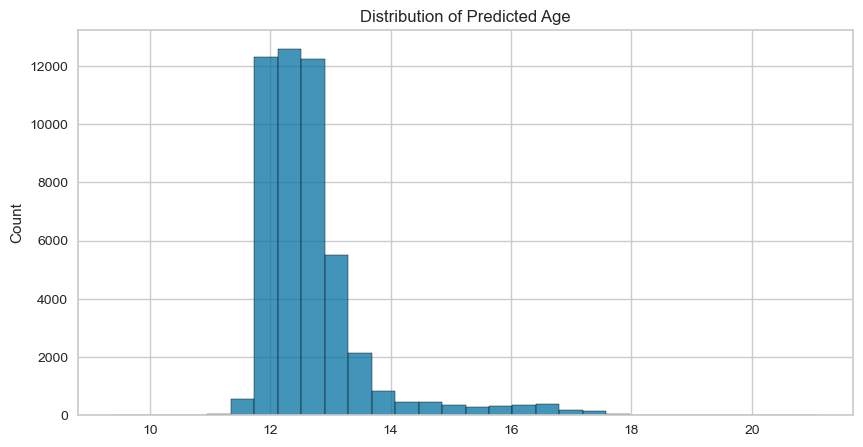

In [88]:
plt.figure(figsize=(10,5))
sns.histplot(y_test_pred1, bins=30)
plt.title('Distribution of Predicted Age')
plt.show()

In [87]:
y_test_pred2 = tuned_catboost_model.predict(X_test)

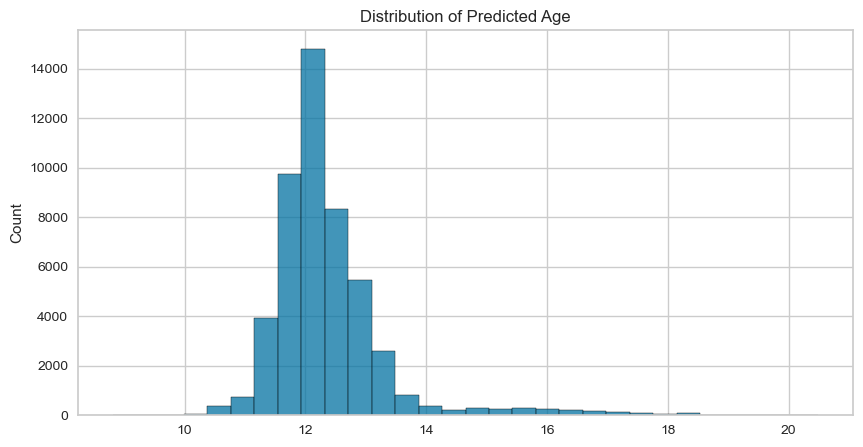

In [89]:
plt.figure(figsize=(10,5))
sns.histplot(y_test_pred2, bins=30)
plt.title('Distribution of Predicted Age')
plt.show()

In [90]:
submission = pd.DataFrame( {
    'id': test_ids, 
    'Age': y_test_pred1
})
print(submission.head(20))

       id        Age
0   74051  12.616801
1   74052  12.631376
2   74053  13.474033
3   74054  12.604930
4   74055  12.631924
5   74056  12.135532
6   74057  12.342418
7   74058  12.631376
8   74059  13.869878
9   74060  13.015097
10  74061  11.852130
11  74062  12.402900
12  74063  14.705639
13  74064  12.378567
14  74065  16.813794
15  74066  15.531901
16  74067  12.188979
17  74068  12.061350
18  74069  12.994548
19  74070  11.983940


In [73]:
submission.describe().T

count          mean           std           min          25%  \
id   49368.0  98734.500000  14251.458382  74051.000000  86392.75000   
Age  49368.0     12.653658      0.950098      9.392683     12.06135   

              50%            75%            max  
id   98734.500000  111076.250000  123418.000000  
Age     12.488194      12.846743      21.095503

In [92]:
submission_v2 = pd.DataFrame( {
    'id': test_ids, 
    'Age': y_test_pred2
})
submission_v2.head(20)

id        Age
0   74051  12.932100
1   74052  12.912895
2   74053  13.039663
3   74054  12.020038
4   74055  12.782860
5   74056  11.964544
6   74057  12.173339
7   74058  12.912895
8   74059  13.503089
9   74060  12.488975
10  74061  11.555684
11  74062  11.952378
12  74063  14.316040
13  74064  12.104083
14  74065  16.548469
15  74066  14.948146
16  74067  12.095330
17  74068  11.931041
18  74069  12.813752
19  74070  11.661888

In [93]:
submission_v2.describe().T

count          mean           std           min           25%  \
id   49368.0  98734.500000  14251.458382  74051.000000  86392.750000   
Age  49368.0     12.354656      0.989832      8.820452     11.730583   

              50%            75%            max  
id   98734.500000  111076.250000  123418.000000  
Age     12.170674      12.617554      20.481989

In [94]:
#Tuned model을 사용했을 때 조금더 다양한 분포로 나타남